In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
#from evaluation_functions import ensemble_evaluation_functions as eef
#import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os
import time

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number

# ensemble functions
import huxt_ensemble_functions as hef 
import calibration_functions as cf

In [2]:
def ICMElist(filepath = None):
    # -*- coding: utf-8 -*-
    """
    A script to read and process Ian Richardson's ICME list.

    Some pre-processing is required:
        Download the following webpage as a html file: 
            http://www.srl.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm
        Open in Excel, remove the year rows, delete last column (S) which is empty
        Cut out the data table only (delete header and footer)
        Save as a CSV.

    """
    
    if filepath is None:
        datapath =  system._setup_dirs_()['datapath']
        filepath = os.path.join(datapath,
                                'icmetable.csv')
    
    
    icmes=pd.read_csv(filepath,header=None)
    #delete the first row
    icmes.drop(icmes.index[0], inplace=True)
    icmes.index = range(len(icmes))
    
    for rownum in range(0,len(icmes)):
        for colnum in range(0,3):
            #convert the three date stamps
            datestr=icmes[colnum][rownum]
            year=int(datestr[:4])
            month=int(datestr[5:7])
            day=int(datestr[8:10])
            hour=int(datestr[11:13])
            minute=int(datestr[13:15])
            #icmes.set_value(rownum,colnum,datetime(year,month, day,hour,minute,0))
            icmes.at[rownum,colnum] = datetime.datetime(year,month, day,hour,minute,0)
            
        #tidy up the plasma properties
        for paramno in range(10,17):
            dv=str(icmes[paramno][rownum])
            if dv == '...' or dv == 'dg' or dv == 'nan':
                #icmes.set_value(rownum,paramno,np.nan)
                icmes.at[rownum,paramno] = np.nan
            else:
                #remove any remaining non-numeric characters
                dv=re.sub('[^0-9]','', dv)
                #icmes.set_value(rownum,paramno,float(dv))
                icmes.at[rownum,paramno] = float(dv)
        
    
    #chage teh column headings
    icmes=icmes.rename(columns = {0:'Shock_time',
                                  1:'ICME_start',
                                  2:'ICME_end',
                                  10:'dV',
                                  11: 'V_mean',
                                  12:'V_max',
                                  13:'Bmag',
                                  14:'MCflag',
                                  15:'Dst',
                                  16:'V_transit'})
    return icmes

def compute_lead_time_stats(df):

    df_ = df.copy()
    
    # Calculating the statistics
    df_['mean'] = df_.mean(axis=1)
    df_['median'] = df_.median(axis=1)
    df_['min'] = df_.min(axis=1)
    df_['max'] = df_.max(axis=1)
    df_['lower_1_sigma'] = df_.apply(lambda row: np.percentile(row, 15.87), axis=1)
    df_['upper_1_sigma'] = df_.apply(lambda row: np.percentile(row, 84.13), axis=1)
    df_['lower_2_sigma'] = df_.apply(lambda row: np.percentile(row, 2.28), axis=1)
    df_['upper_2_sigma'] = df_.apply(lambda row: np.percentile(row, 97.72), axis=1)

    return df_

def date_from_ensemble_folder_name(fname):
    
    """
    extracts date from wsa filename

    Args:
        fname (string) : name of ensemble file set
    Returns:
        date_string (string) : date string generated from info within file string format
        date_obj (datetime) : datetime object from file name
    """

    pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
    match = re.search(pattern, fname)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'
    date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')

    return date_string, date_obj

In [3]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
#omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

## Create verificaton dataset with ICMEs removed from the timeseries
df_ICME = ICMElist("C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_Calibration\\data\\icmetable.csv")
df_ICME = df_ICME.set_index('Shock_time')

# Create a list of ICME (start,end) times 
CME_flags = [*zip(df_ICME.loc['2020':'2023']['ICME_start'], df_ICME.loc['2020':'2023']['ICME_end'])]

# Loop through ICME timing list and remove observations within CME start/end crossing period.
df_temp = omni_data.copy()
for start_time, end_time in CME_flags:
    
    # Replace values with NaN for rows within the specified time period
    df_temp.loc[(df_temp.index >= start_time) & (df_temp.index <= end_time)] = np.nan

    # Remove from time_series 
    #df_filtered = df_temp[~((df_temp.index >= start_time) & (df_temp.index <= end_time))]
    #df_temp = df_filtered.copy()

df_filtered = df_temp.copy()  

c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [7]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 5 # degrees
sigma_longitude = 5 # degrees
forecast_window = 10 * u.day
r_min = 21.5*u.solRad
year_str = '2023'

year_id = {'2023':'_2023', '2020':'_2020'} # awkward file string formating stuff which will be removed when I fix the file name consistency

# get all ensemble netCDF file strings of specified parameters
ensemble_directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
ensemble_file_words = [f'ens_{int(sigma_latitude)}_{ensemble_size}_wsa{year_id[year_str]}'] # keywords to filter ensemble set directory
ensemble_fname = hef.get_files_containing_words(ensemble_directory_path, ensemble_file_words)[0]
all_files = os.listdir(os.path.abspath(os.path.join(os.pardir,'data','ensembles',ensemble_fname))) # list of all files inside ensemble directory
dates = []
filenames = []

# creating list of filenames of ensemble files for reading in ensembles over a specfied date range
for filename in all_files:

    #unpack ensemble datenum into an indexable datetime obj
    pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
    match = re.search(pattern, filename)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'
    dates.append(datetime.datetime(int(year), int(month), int(day), int(hour)))

# index ensemble filenames by date
df_ens_filenames = pd.DataFrame({'file_string' : all_files}, index = dates)
df_ens_filenames = df_ens_filenames.sort_index()

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)

date_range = pd.date_range(start_date, end_date, freq='D') # daily frequency

# Finding closest indices
indexer = df_ens_filenames.index.get_indexer(date_range, method='nearest')

# Retrieving the closest rows
closest_files = df_ens_filenames.iloc[indexer]

# Dropping duplicates to keep only unique rows -- unlikely for any duplicates but just in case :/ 
unique_files = closest_files[~closest_files.index.duplicated(keep='first')]

# list of ensemble netCDF filenames within date_range
fname_list = unique_files['file_string'].to_list()


daily_ensemble_sets = []
updated_data_chunks = []

for fname in fname_list:
    date_string, date_obj = date_from_ensemble_folder_name(fname)
    random_seed = int(date_obj.strftime("%y%m%d%H%M"))

    # read in ensemble members and perturb longitudinally
    ensemble_members = hef.read_ens_cdf(date_string=date_string, sigma_latitude=sigma_latitude, ensemble_size=ensemble_size, coronal_model='wsa', year=year_str)
    lp_ens_members = hef.perturb_ensemble_longitudinally(ensemble_members=ensemble_members, sigma_longitude=sigma_longitude, 
                                                            ensemble_size=ensemble_size, random_seed=random_seed)
    
    # # Add unique suffixes to the column names
    # renamed_dfs = [df.add_suffix(f"_{i}") for i, df in enumerate(lp_ens_members)]

    # ensemble_members_df = pd.concat(renamed_dfs, axis=1)
    # ensemble_members_df.index.name = None

    observed_df = df_filtered['V'][lp_ens_members[0].index[0]:lp_ens_members[0].index[-1]]
    resampled_ensemble_data = [hef.interpolate_and_resample(observed_data=observed_df, forecast_series=ens_mem) for ens_mem in lp_ens_members]

    resampled_ensembles_df = pd.DataFrame(np.stack(resampled_ensemble_data).T, index=observed_df.index, columns=[f'vsw_{i}' for i in range(ensemble_size)])
    resampled_ensembles_df['observation'] = observed_df

    #append to main storage list
    daily_ensemble_sets.append(resampled_ensembles_df)
    updated_data_chunks.append(observed_df)

TypeError: read_ens_cdf() missing 1 required positional argument: 'gen_dist'

In [4]:
def read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude,  year_str, start_date, end_date, gen_dist):

    year_id = {'2023':'_2023', '2020':'_2020'} # awkward file string formating stuff which will be removed when I fix the file name consistency

    # get all ensemble netCDF file strings of specified parameters
    ensemble_directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
    ensemble_file_words = [f'ens_{int(sigma_latitude)}_{ensemble_size}_wsa{year_id[year_str]}{gen_dist}'] # keywords to filter ensemble set directory
    print(ensemble_file_words)
    ensemble_fname = hef.get_files_containing_words(ensemble_directory_path, ensemble_file_words)[0]
    all_files = os.listdir(os.path.abspath(os.path.join(os.pardir,'data','ensembles',ensemble_fname))) # list of all files inside ensemble directory
    dates = []
    filenames = []

    # creating list of filenames of ensemble files for reading in ensembles over a specfied date range
    for filename in all_files:

        #unpack ensemble datenum into an indexable datetime obj
        pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
        match = re.search(pattern, filename)
        year, month, day, hour = match.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        dates.append(datetime.datetime(int(year), int(month), int(day), int(hour)))

    # index ensemble filenames by date
    df_ens_filenames = pd.DataFrame({'file_string' : all_files}, index = dates)
    df_ens_filenames = df_ens_filenames.sort_index()

    date_range = pd.date_range(start_date, end_date, freq='D') # daily frequency

    # Finding closest indices
    indexer = df_ens_filenames.index.get_indexer(date_range, method='nearest')

    # Retrieving the closest rows
    closest_files = df_ens_filenames.iloc[indexer]

    # Dropping duplicates to keep only unique rows -- unlikely for any duplicates but just in case :/ 
    unique_files = closest_files[~closest_files.index.duplicated(keep='first')]

    # list of ensemble netCDF filenames within date_range
    fname_list = unique_files['file_string'].to_list()

    daily_ensemble_sets = []
    updated_data_chunks = []

    for fname in fname_list:
        date_string, date_obj = date_from_ensemble_folder_name(fname)
        random_seed = int(date_obj.strftime("%y%m%d%H%M"))

        # read in ensemble members and perturb longitudinally
        ensemble_members = hef.read_ens_cdf(date_string=date_string, sigma_latitude=sigma_latitude, ensemble_size=ensemble_size, coronal_model='wsa', year=year_str, gen_dist=gen_dist)
        lp_ens_members = hef.perturb_ensemble_longitudinally(ensemble_members=ensemble_members, sigma_longitude=sigma_longitude, 
                                                                ensemble_size=ensemble_size, random_seed=random_seed)

        observed_df = df_filtered['V'][lp_ens_members[0].index[0]:lp_ens_members[0].index[-1]]
        resampled_ensemble_data = [hef.interpolate_and_resample(observed_data=observed_df, forecast_series=ens_mem) for ens_mem in lp_ens_members]

        resampled_ensembles_df = pd.DataFrame(np.stack(resampled_ensemble_data).T, index=observed_df.index, columns=[f'vsw_{i}' for i in range(ensemble_size)])
        resampled_ensembles_df['observation'] = observed_df

        #append to main storage list
        daily_ensemble_sets.append(resampled_ensembles_df)
        updated_data_chunks.append(observed_df)

    return daily_ensemble_sets

In [11]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 0 # degrees
sigma_longitude = 0 # degrees
year_str = '2020'
gen_dist = ''

# specify date range of ensemble to load in
start_date = datetime.datetime(2020,1,1)
end_date = datetime.datetime(2021,1,1)

daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist)

['ens_0_100_wsa_2020']


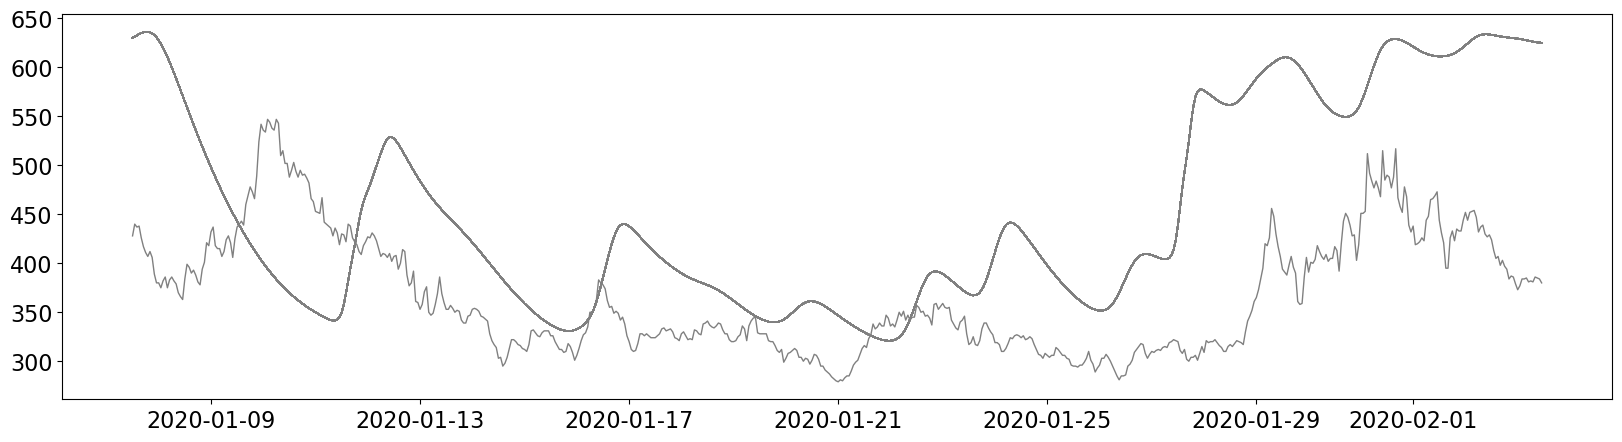

In [12]:
plt.figure(figsize=(20,5))
plt.plot(daily_ensemble_sets[6], lw=1, color='grey')
plt.show()

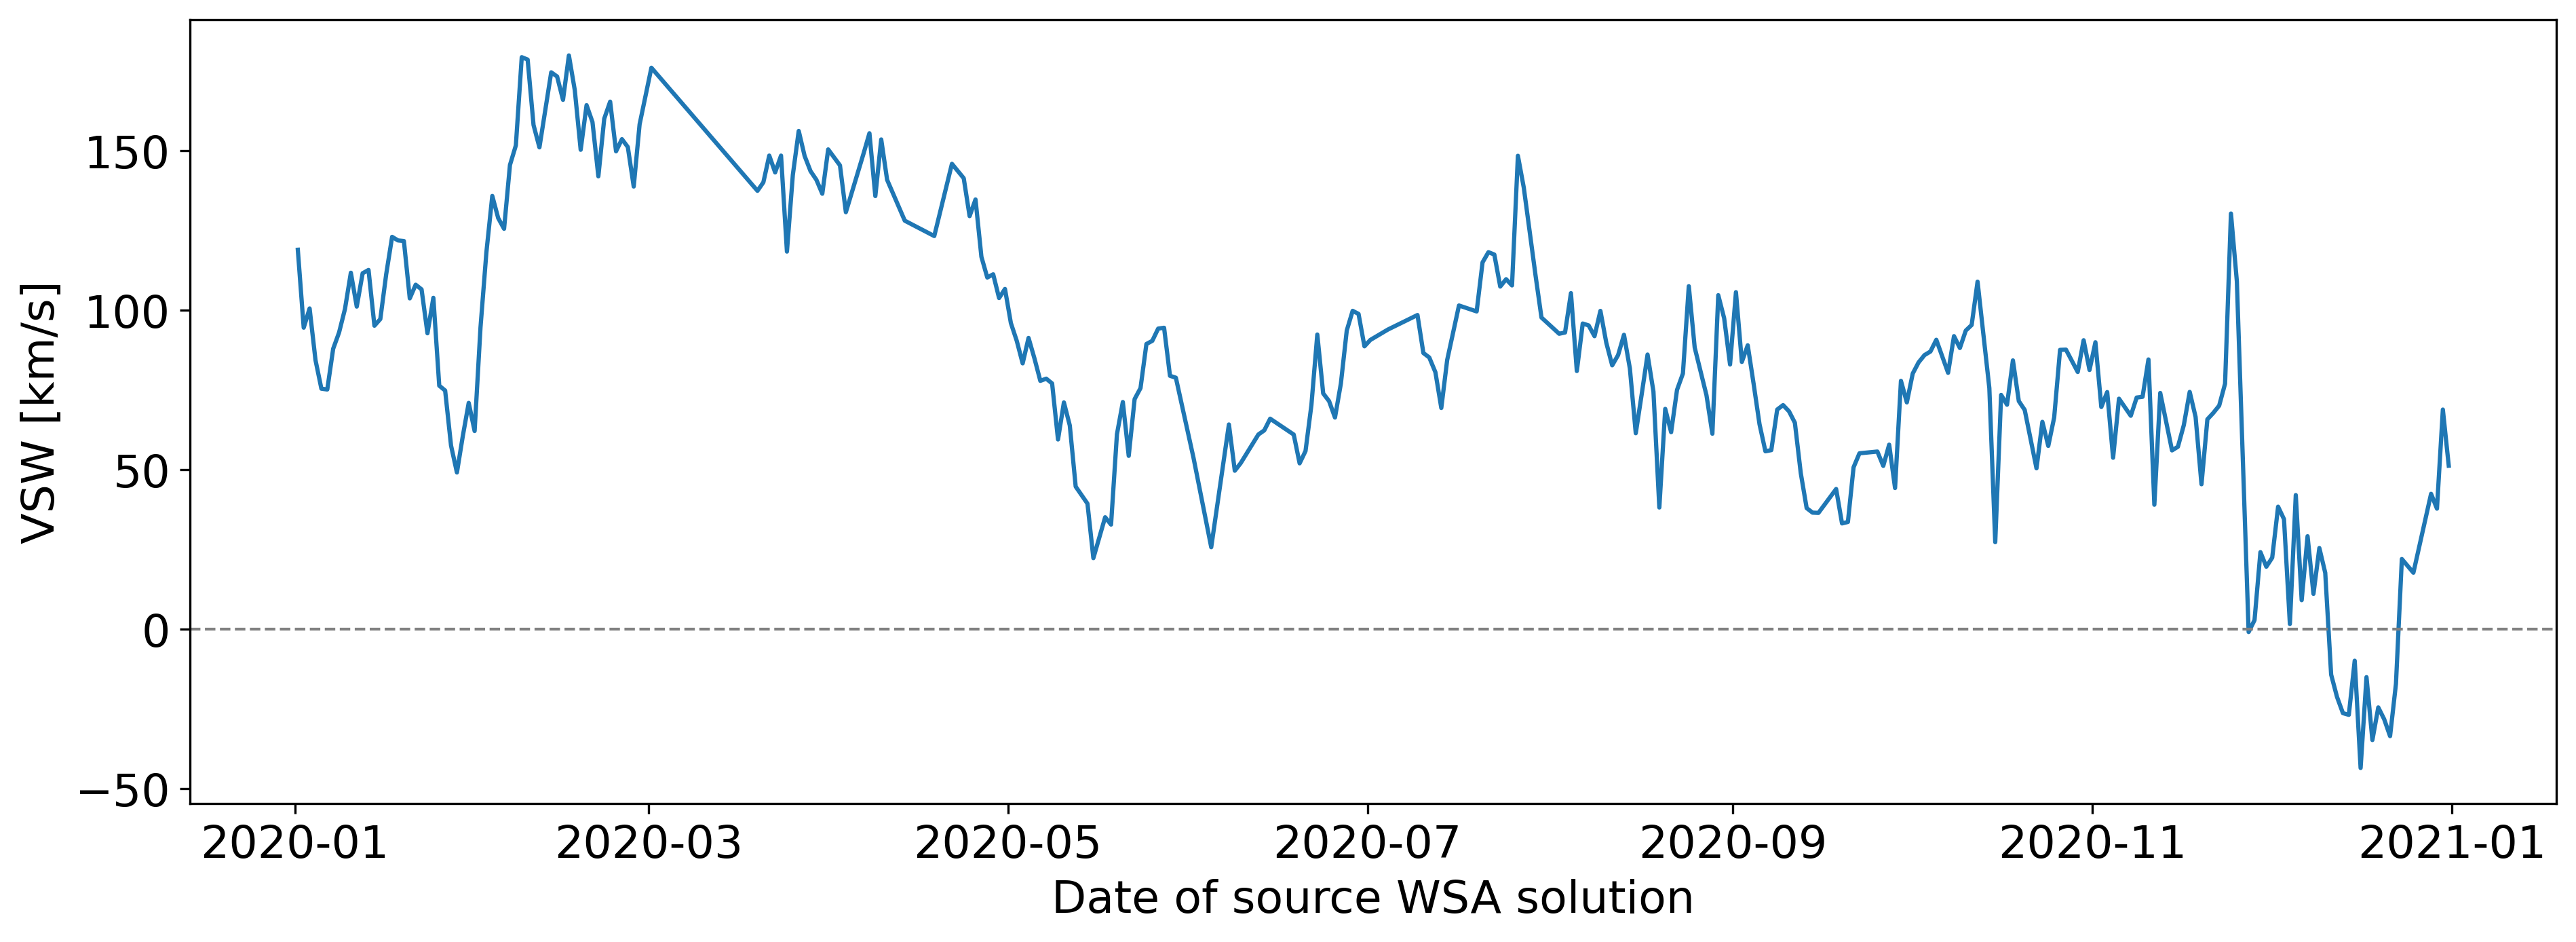

In [13]:
daily_mean_diff = []
daily_diff = []
init_day = []
for df_ in daily_ensemble_sets:
    difference = df_['vsw_0'] - df_['observation']
    mean_difference = np.mean(difference)
    daily_mean_diff.append(mean_difference)
    daily_diff.append(difference)
    init_day.append(df_.index[0])

df_md = pd.DataFrame({'mean_difference':daily_mean_diff}, index=init_day)


plt.figure(figsize=(15,5),dpi=300)
plt.plot(init_day, daily_mean_diff)
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.xlabel('Date of source WSA solution')
plt.ylabel('VSW [km/s]')
plt.show()


In [6]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20,5))

# # Initialize the plot with the first image

# line = ax.plot(daily_ensemble_sets[0].filter(like='vsw'), lw=1, color='black', alpha=0.5)
# ax.plot(updated_data_chunks[0], lw = 2, color = 'red')
# ax.set_ylim(250,750)

# # Function to update the image on each frame
# def update(frame):

#     ax.clear()
#     ax.plot(daily_ensemble_sets[frame].filter(like='vsw'), lw=1, color='black', alpha=0.5)
#     ax.plot(updated_data_chunks[frame], lw = 1, color = 'red')
#     ax.set_ylim(250,750)

#     return line

# # Create the animation object
# ani = FuncAnimation(fig, update, frames=50, interval=100, blit=True, repeat_delay=2500)
# #ani.save('daily_updated_ensemble.gif', writer='imagemagick')
# HTML(ani.to_jshtml())

In [ ]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 5 # degrees
sigma_longitude = 7 # degrees
year_str = '2020'
gen_dist = '_fullrot'

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)

daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist=gen_dist)

['ens_5_100_wsa_2023_fullrot']


direct integration: term 1 = 4.870, term 2 = 8.179, crps = 13.049
discrete sum: term 1 = 4.958, term 2 = 8.342, crps = 13.300


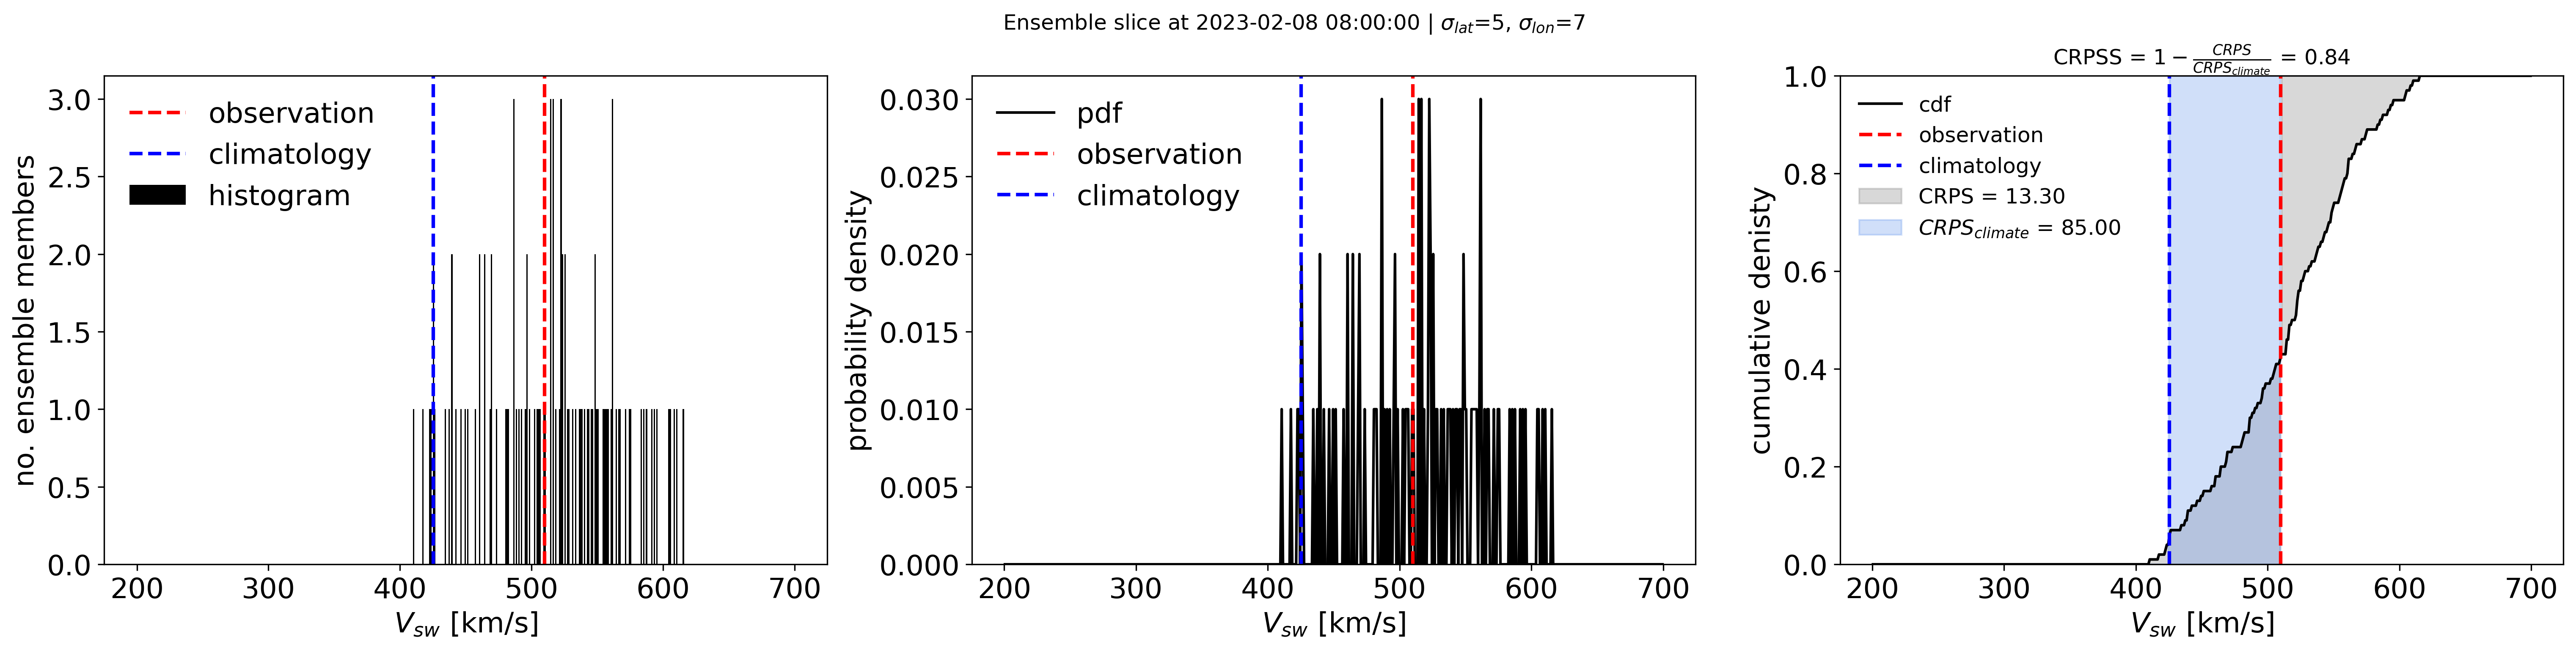

In [7]:
ensemble_slice = daily_ensemble_sets[30].iloc[200].filter(like='vsw')
observation = daily_ensemble_sets[30].iloc[200]['observation']


climatology = df_filtered.loc['2023']['V'].mean()

lower_limit = 200
upper_limit = 700
n_bins = upper_limit - lower_limit + 1
#n_bins = 400

# get ensemble distribution
bin_edges = np.linspace(lower_limit, upper_limit, n_bins)
ensemble_hist, bin_edges = np.histogram(ensemble_slice, bins=bin_edges)

# Compute bin widths
bin_widths = np.diff(bin_edges)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

# Convert to probability densities
pdf = ensemble_hist / (np.sum(ensemble_hist) * bin_widths)

# Compute CDF
cdf = np.cumsum(ensemble_hist)  
cdf = cdf / cdf[-1]    # Normalize to get values between 0 and 1


term1_index = bin_centres <= observation
term2_index = bin_centres > observation

term1 = integrate.trapezoid(cdf[term1_index]**2, bin_centres[term1_index])
term2 = integrate.trapezoid((cdf[term2_index]-1)**2, bin_centres[term2_index])
crps_int = term1 + term2

print(f'direct integration: term 1 = {term1:.3f}, term 2 = {term2:.3f}, crps = {crps_int:.3f}')

term1_disc = np.sum((cdf[term1_index]*bin_widths[term1_index])**2)
term2_disc = np.sum(((cdf[term2_index]-1)*bin_widths[term2_index])**2)
crps_disc = term1_disc + term2_disc

print(f'discrete sum: term 1 = {term1_disc:.3f}, term 2 = {term2_disc:.3f}, crps = {crps_disc:.3f}')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,5), dpi=300)

fig.suptitle(f'Ensemble slice at {ensemble_slice.name} | $\sigma_{{lat}}$={sigma_latitude}, $\sigma_{{lon}}$={sigma_longitude}')

axes[0].bar(bin_centres, ensemble_hist, width = bin_widths, color='black', label='histogram')
axes[0].axvline(observation, lw=2, color='red', linestyle = '--', label='observation')
axes[0].axvline(climatology, lw=2, color='blue', linestyle = '--', label='climatology')
axes[0].set_xlabel(r'$V_{sw}$ [km/s]')
axes[0].set_ylabel('no. ensemble members')
axes[0].legend(frameon=False)


axes[1].plot(bin_centres, pdf, color='black', label = 'pdf')
axes[1].axvline(observation, lw=2, color='red', linestyle = '--', label='observation')
axes[1].axvline(climatology, lw=2, color='blue', linestyle = '--', label='climatology')
axes[1].set_xlabel(r'$V_{sw}$ [km/s]')
axes[1].set_ylabel('probability density')
axes[1].legend(frameon=False)
axes[1].set_ylim(0)


# gen cdfs for plotting + computing climatological CRPS
observations_cdf = np.cumsum(np.histogram(observation, bin_edges, density=True)[0])
climatology_cdf = np.cumsum(np.histogram(climatology, bin_edges, density=True)[0])

#compute crps for climatology
term1_climate = np.sum((climatology_cdf[term1_index]*bin_widths[term1_index])**2)
term2_climate = np.sum(((climatology_cdf[term2_index]-1)*bin_widths[term2_index])**2)
crps_climate = term1_climate + term2_climate

axes[2].plot(bin_centres, cdf, color='black', label = 'cdf')
axes[2].axvline(observation, lw=2, color='red', linestyle = '--', label='observation')
axes[2].axvline(climatology, lw=2, color='blue', linestyle = '--', label='climatology')

axes[2].fill_between(bin_centres[term1_index], cdf[term1_index], observations_cdf[term1_index], color='gray', alpha=0.3, label = f'CRPS = {crps_disc:.2f}')
axes[2].fill_between(bin_centres[term2_index], observations_cdf[term2_index], cdf[term2_index], color='gray', alpha=0.3)

axes[2].fill_between(bin_centres[term1_index], climatology_cdf[term1_index], observations_cdf[term1_index], color='cornflowerblue', alpha=0.3, label = f'$CRPS_{{climate}}$ = {crps_climate:.2f}')
axes[2].fill_between(bin_centres[term2_index], observations_cdf[term2_index], climatology_cdf[term2_index], color='cornflowerblue', alpha=0.3)

axes[2].set_xlabel(r'$V_{sw}$ [km/s]')
axes[2].set_ylabel('cumulative denisty')
axes[2].legend(frameon=False, fontsize = 'large')
axes[2].set_ylim(0,1)
axes[2].set_title(f'CRPSS = $1 - \\frac{{CRPS}}{{CRPS_{{climate}}}}$ = {(1 - (crps_disc/crps_climate)):.2f}')

plt.show()

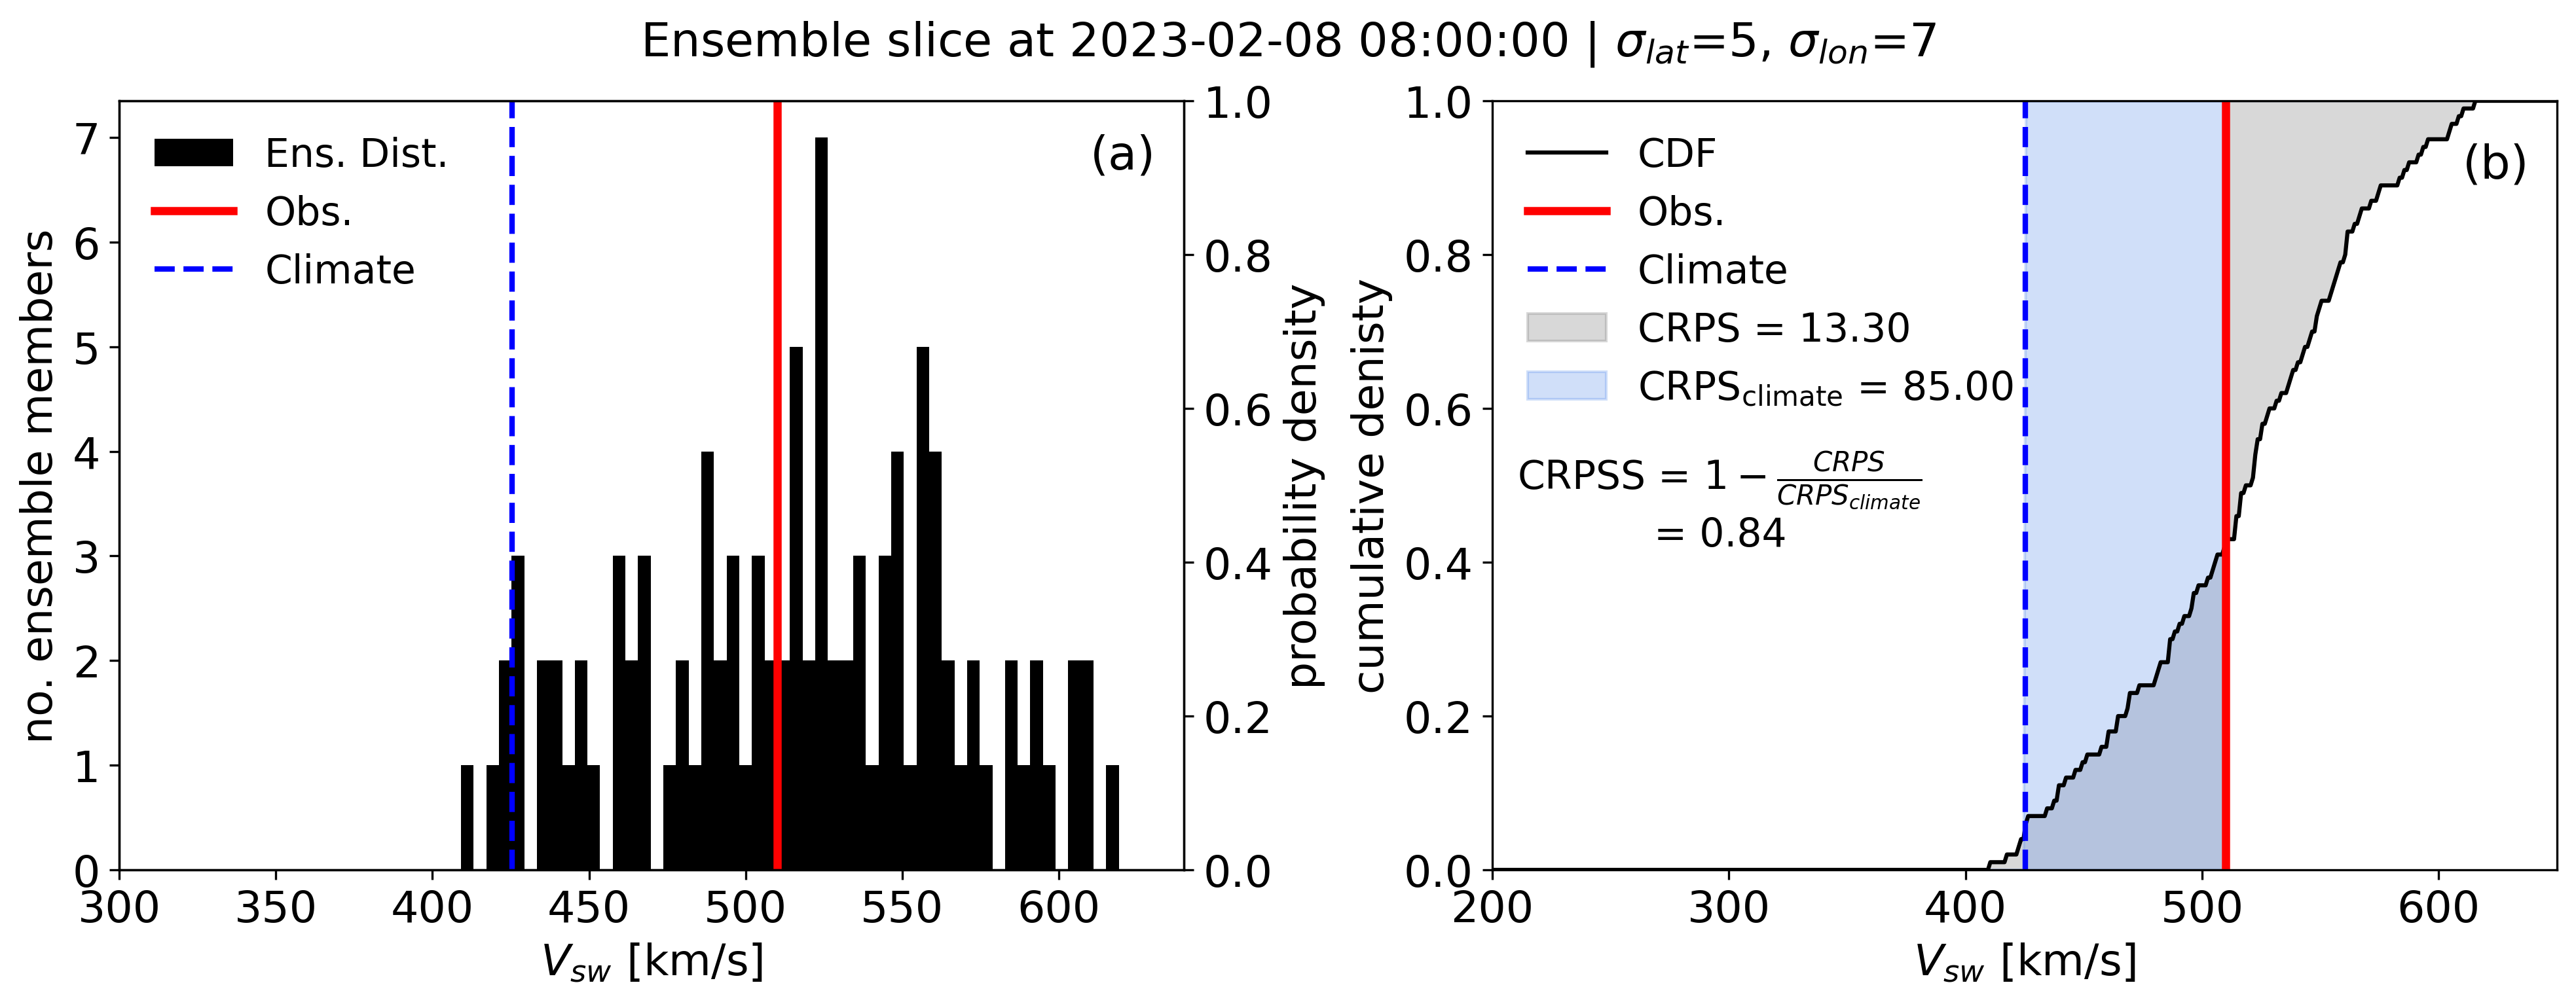

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5), dpi=300, constrained_layout=True)

fig.suptitle(f'Ensemble slice at {ensemble_slice.name} | $\sigma_{{lat}}$={sigma_latitude}, $\sigma_{{lon}}$={sigma_longitude}', fontsize='xx-large')

#axes[0].bar(bin_centres, ensemble_hist, width = bin_widths, color='black', label='histogram')
axes[0].hist(ensemble_slice, bins = np.linspace(300,700,100), color = 'black', label = 'Ens. Dist.')
axes[0].axvline(observation, lw=3, color='red', linestyle = '-', label='Obs.')
axes[0].axvline(climatology, lw=2, color='blue', linestyle = '--', label='Climate')
axes[0].set_xlabel(r'$V_{sw}$ [km/s]')
axes[0].set_ylabel('no. ensemble members')
axes[0].legend(frameon=False, fontsize='x-large', loc='upper left')
axes[0].set_xlim(300,640)

# putting pdf axes 
ax2 = axes[0].twinx()
ax2.yaxis.set_label_position("right")
ax2.set_yticks(np.linspace(0,1,6))
ax2.set_ylabel('probability density')

# gen cdfs for plotting + computing climatological CRPS
observations_cdf = np.cumsum(np.histogram(observation, bin_edges, density=True)[0])
climatology_cdf = np.cumsum(np.histogram(climatology, bin_edges, density=True)[0])

#compute crps for climatology
term1_climate = np.sum((climatology_cdf[term1_index]*bin_widths[term1_index])**2)
term2_climate = np.sum(((climatology_cdf[term2_index]-1)*bin_widths[term2_index])**2)
crps_climate = term1_climate + term2_climate

axes[1].plot(bin_centres, cdf, color='black', label = 'CDF')
axes[1].axvline(observation, lw=3, color='red', linestyle = '-', label='Obs.')
axes[1].axvline(climatology, lw=2, color='blue', linestyle = '--', label='Climate')

axes[1].fill_between(bin_centres[term1_index], cdf[term1_index], observations_cdf[term1_index], color='gray', alpha=0.3, label = f'CRPS = {crps_disc:.2f}')
axes[1].fill_between(bin_centres[term2_index], observations_cdf[term2_index], cdf[term2_index], color='gray', alpha=0.3)

axes[1].fill_between(bin_centres[term1_index], climatology_cdf[term1_index], observations_cdf[term1_index], color='cornflowerblue', alpha=0.3, label = f'$\mathrm{{CRPS_{{climate}}}}$ = {crps_climate:.2f}')
axes[1].fill_between(bin_centres[term2_index], observations_cdf[term2_index], climatology_cdf[term2_index], color='cornflowerblue', alpha=0.3)

axes[1].set_xlabel(r'$V_{sw}$ [km/s]')
axes[1].set_ylabel('cumulative denisty')
axes[1].legend(frameon=False, fontsize = 'x-large')
axes[1].set_ylim(0,1)
axes[1].set_xlim(200,650)
axes[1].set_title(f'  CRPSS = $1 - \\frac{{CRPS}}{{CRPS_{{climate}}}}$ \n             = {(1 - (crps_disc/crps_climate)):.2f}', y=0.4, loc='left', fontsize='x-large')

axes[0].annotate('(a)', (610,6.7), fontsize='xx-large')
axes[1].annotate('(b)', (610,0.9), fontsize='xx-large')

filename = "CRPSS_demo.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_02\\{filename}"
plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')

plt.show()

### Evaluating the entire ensemble dataset

In [25]:
def crps_discrete(ensemble_slice, observation):

    #print(observation)
    if np.isnan(observation) == True:
        crps_int = np.NaN
        crps_disc = np.NaN

    else:
        lower_limit = 200
        upper_limit = 850
        n_bins = upper_limit - lower_limit + 1

        bin_edges = np.linspace(lower_limit, upper_limit, n_bins)
        ensemble_hist, bin_edges = np.histogram(ensemble_slice, bins=bin_edges)

        # Compute bin widths
        bin_widths = np.diff(bin_edges)
        bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Convert to probability densities
        pdf = ensemble_hist / (np.sum(ensemble_hist) * bin_widths)

        # Compute CDF
        cdf = np.cumsum(ensemble_hist)  
        cdf = cdf / cdf[-1]    # Normalize to get values between 0 and 1

        # compute crps by evaluating the two halves of the cdf split by the observation
        term1_index = bin_centres <= observation
        term2_index = bin_centres > observation

        # term1 = integrate.trapezoid(cdf[term1_index]**2, bin_centres[term1_index])
        # term2 = integrate.trapezoid((cdf[term2_index]-1)**2, bin_centres[term2_index])
        # crps_int = term1 + term2

        term1_disc = np.sum((cdf[term1_index]*bin_widths[term1_index])**2)
        term2_disc = np.sum(((cdf[term2_index]-1)*bin_widths[term2_index])**2)
        crps_disc = term1_disc + term2_disc

        if crps_disc < 1e-5:
            crps_disc = np.NaN

    return crps_disc


In [ ]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 5 # degrees
sigma_longitude = 7 # degrees
year_str = '2023'
gen_dist = '_fullrot'

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)

daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist=gen_dist)

In [30]:
daily_ensemble_sets[0]

vsw_0       vsw_1       vsw_2       vsw_3  \
datetime                                                              
2023-01-01 00:00:00  619.290596  598.922829  609.513632  586.100752   
2023-01-01 01:00:00  617.470310  597.008217  607.986780  583.593668   
2023-01-01 02:00:00  615.608684  594.927469  606.478361  580.865475   
2023-01-01 03:00:00  613.711385  592.626926  604.989446  577.892731   
2023-01-01 04:00:00  611.786286  590.081305  602.705195  574.667864   
...                         ...         ...         ...         ...   
2023-01-28 01:00:00  627.602768  607.695344  617.398115  596.029407   
2023-01-28 02:00:00  626.026477  606.211804  615.778497  594.244065   
2023-01-28 03:00:00  624.397944  604.760457  614.168387  592.387663   
2023-01-28 04:00:00  622.718977  602.283511  612.573805  590.415190   
2023-01-28 05:00:00  620.990347  600.579755  611.000358  588.292091   

                          vsw_4       vsw_5       vsw_6       vsw_7  \
datetime                                                              
2023-01-01 00:00:00  589.062714  592.154416  609.695705  591.505966   
2023-01-01 01:00:00  585.365372  589.924962  608.285807  588.220356   
2023-01-01 02:00:00  581.423360  587.601719  605.667503  584.711583   
2023-01-01 03:00:00  577.241150  585.113693  604.090933  580.937660   
2023-01-01 04:00:00  572.838047  582.436017  602.285673  576.914098   
...                         ...         ...         ...         ...   
2023-01-28 01:00:00  603.463883  603.234981  616.516420  603.766059   
2023-01-28 02:00:00  601.040567  601.326192  615.125131  601.725739   
2023-01-28 03:00:00  598.390805  598.184591  613.748421  599.486614   
2023-01-28 04:00:00  595.491967  596.155734  612.380179  597.020728   
2023-01-28 05:00:00  592.328637  594.118687  611.009494  594.305891   

                          vsw_8       vsw_9  ...      vsw_94      vsw_95  \
datetime                                     ...                           
2023-01-01 00:00:00  625.529793  608.021969  ...  592.535561  537.905370   
2023-01-01 01:00:00  623.914414  606.258737  ...  588.809788  533.087162   
2023-01-01 02:00:00  622.270170  604.521150  ...  584.910110  528.239676   
2023-01-01 03:00:00  620.594105  602.823736  ...  580.767937  523.365596   
2023-01-01 04:00:00  618.889468  600.024592  ...  576.404856  518.480442   
...                         ...         ...  ...         ...         ...   
2023-01-28 01:00:00  632.734192  616.884050  ...  606.797951  560.370336   
2023-01-28 02:00:00  631.437867  615.108703  ...  604.365819  556.088974   
2023-01-28 03:00:00  630.037165  613.317857  ...  601.720711  551.657864   
2023-01-28 04:00:00  628.562156  611.520898  ...  598.840107  547.099165   
2023-01-28 05:00:00  627.031961  609.727953  ...  595.705922  542.436095   

                         vsw_96      vsw_97      vsw_98      vsw_99  \
datetime                                                              
2023-01-01 00:00:00  586.195977  578.055969  613.521961  603.336911   
2023-01-01 01:00:00  583.589874  574.338476  611.634371  601.473985   
2023-01-01 02:00:00  580.806340  570.441631  609.740147  599.462543   
2023-01-01 03:00:00  577.770444  566.327074  607.845523  597.228863   
2023-01-01 04:00:00  574.476700  562.016606  605.956850  594.746580   
...                         ...         ...         ...         ...   
2023-01-28 01:00:00  596.262001  592.425484  622.491306  611.668510   
2023-01-28 02:00:00  594.436268  590.000199  620.753907  610.269277   
2023-01-28 03:00:00  592.546358  587.343955  618.975173  608.859678   
2023-01-28 04:00:00  590.540092  584.437959  617.159838  607.286187   
2023-01-28 05:00:00  588.380921  581.273645  615.312762  604.827789   

                     observation     crps  crps_climate     crpss  
datetime                                                           
2023-01-01 00:00:00        603.0   6.7425         178.0  0.962121  
2023-01-01 01:00:00        582.0  10.7362         157.0  0.93

In [26]:
#evaluate crps for each ensemble by timestep 
for df_ in daily_ensemble_sets:
    crps_list = np.array([crps_discrete(df_.iloc[i].filter(like='vsw'), df_.iloc[i]['observation']) for i in range(df_.shape[0])])
    df_['crps'] = crps_list # add evaluations as a column in ensemble dataframe

    #evaluate climatology and skill score for each ensemble 
    crps_climate = np.array([crps_discrete(climatology, df_.iloc[i]['observation']) for i in range(df_.shape[0])])
    df_['crps_climate'] = crps_climate # add evaluations as a column in ensemble dataframe#
    df_['crpss'] = 1 - (df_['crps']/df_['crps_climate'])



C:\Users\ct832900\AppData\Local\Temp\ipykernel_21460\2363095511.py:12: RuntimeWarning: Mean of empty slice
  crps_lead_time.append(np.nanmean([crps[index] for crps in crps_sets]))
c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


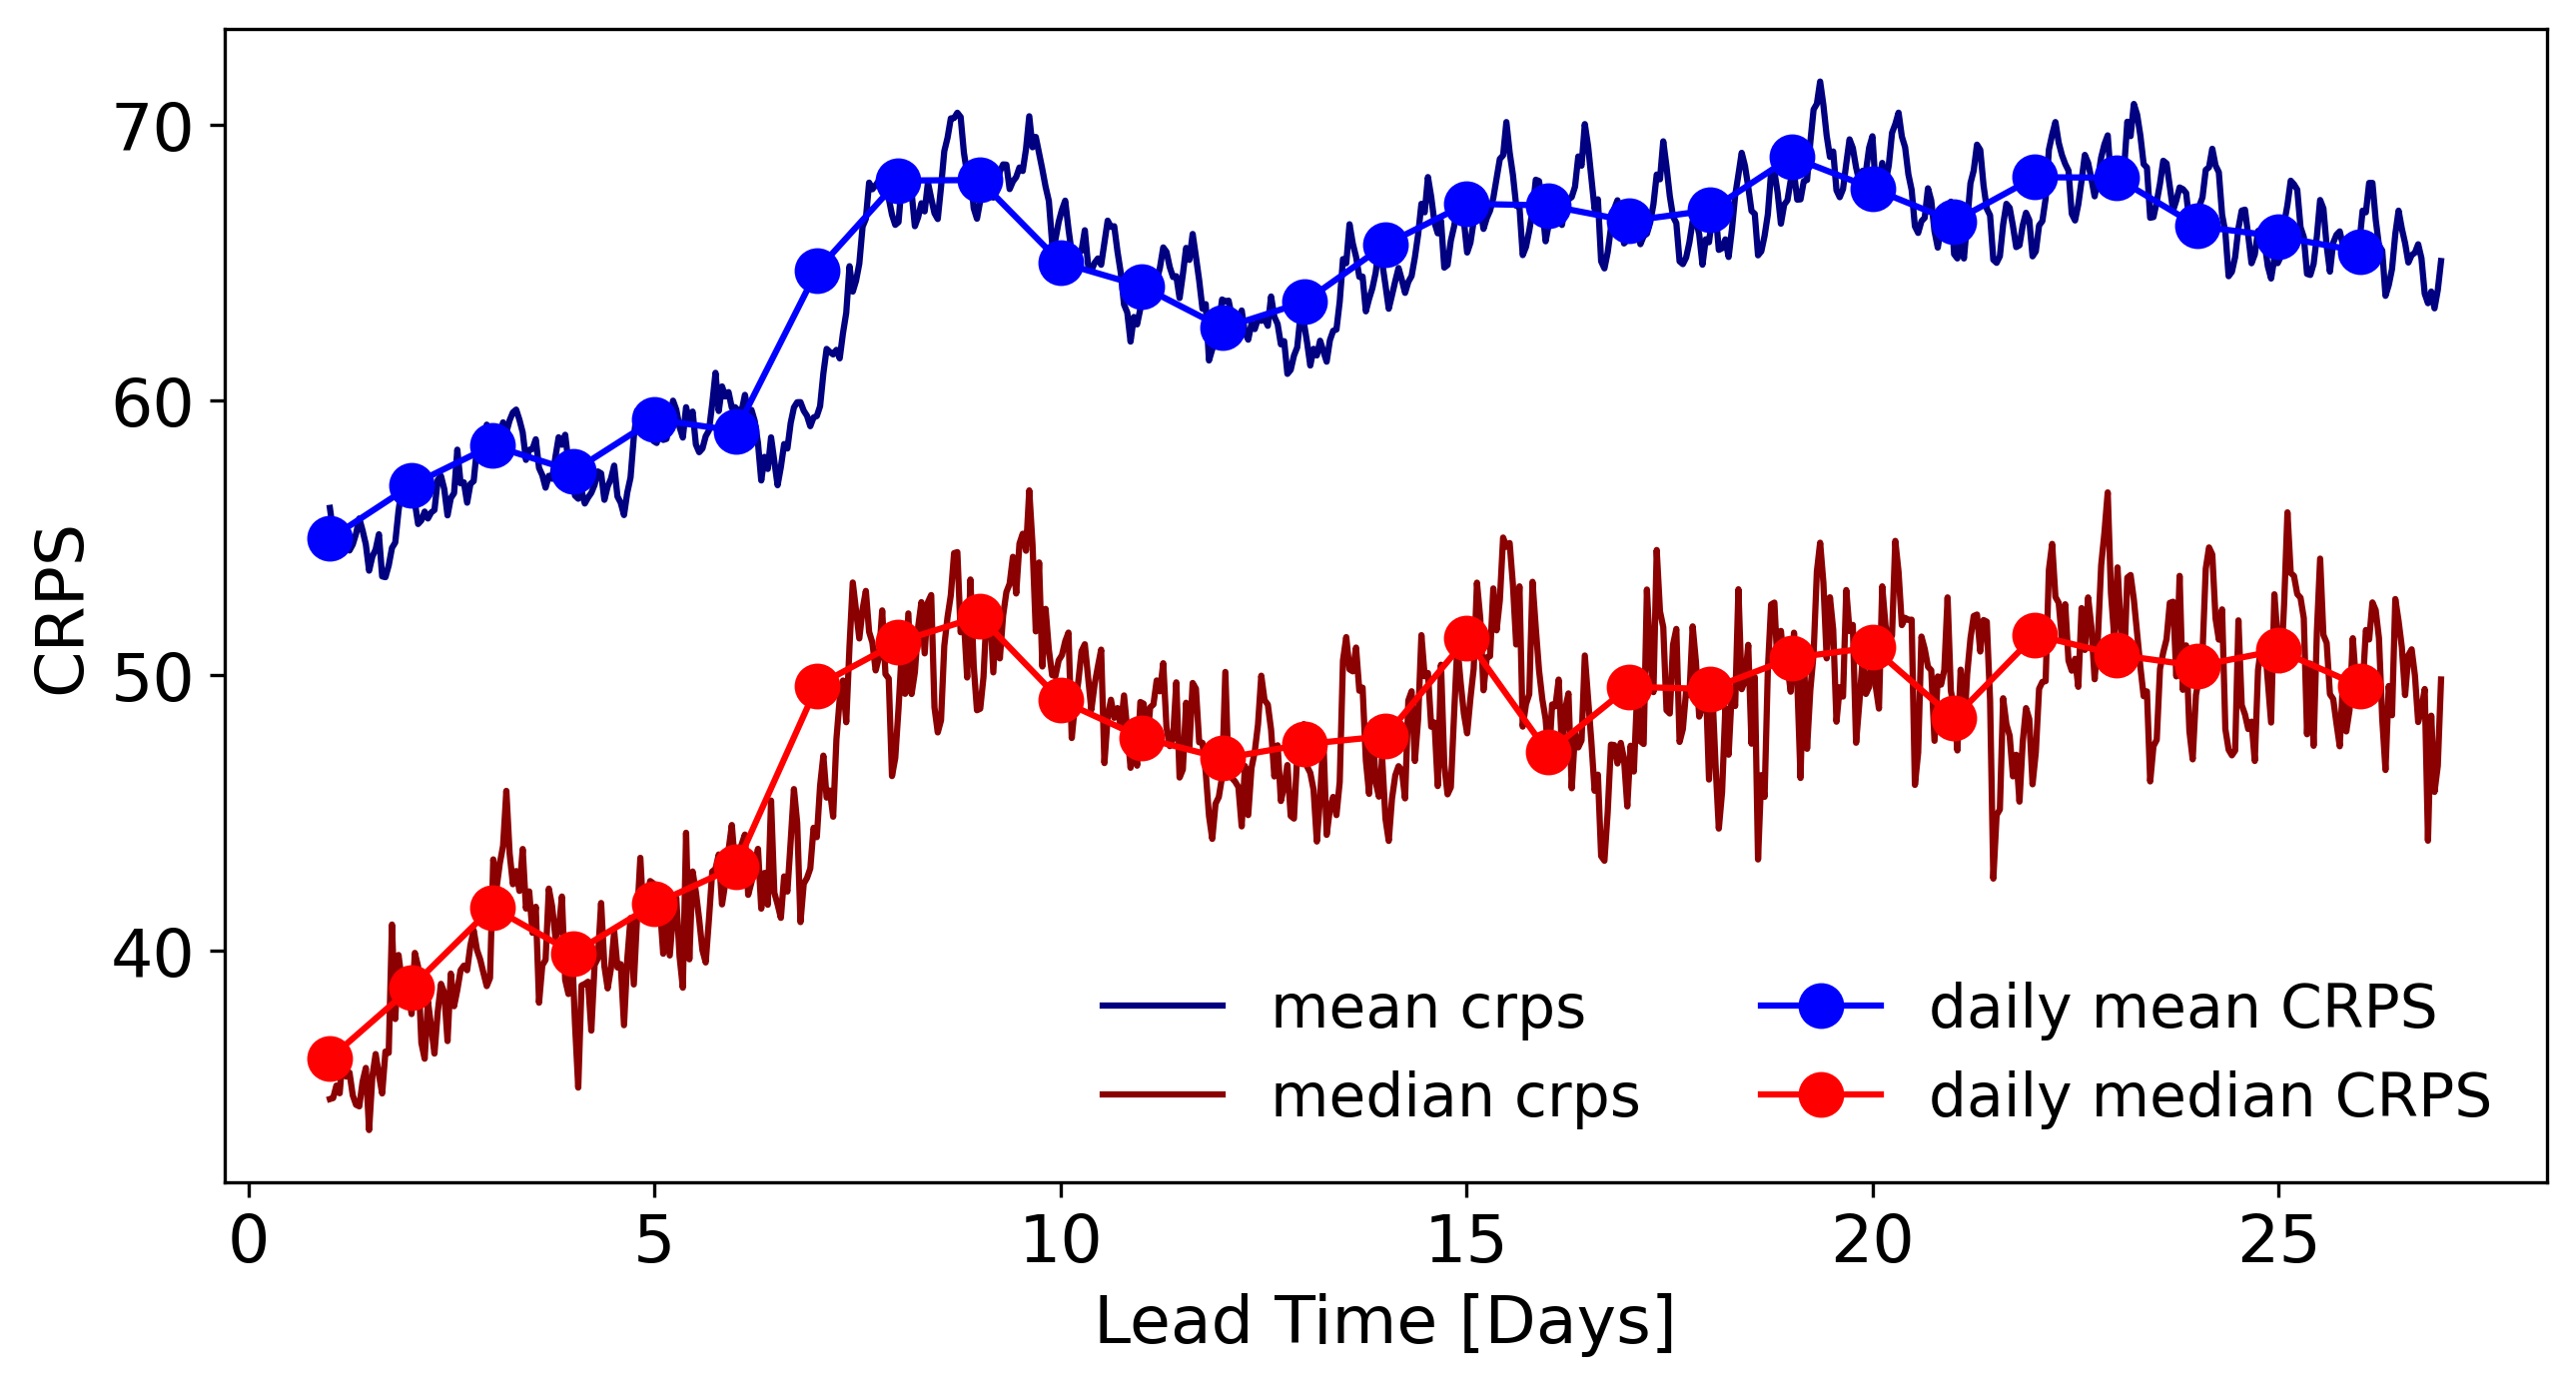

In [28]:
crps_sets = []
for df_ in daily_ensemble_sets:
    crps_sets.append(df_['crps'].iloc[0:647])

max_lead_time = 27 # days
lead_time_axis = np.linspace(1,max_lead_time,647)

crps_lead_time = []
crps_median = []
for i in range(max_lead_time):
    index = (lead_time_axis > i+1) & (lead_time_axis < (i+2))
    crps_lead_time.append(np.nanmean([crps[index] for crps in crps_sets]))
    crps_median.append(np.nanmedian([crps[index] for crps in crps_sets]))

plt.figure(figsize = (10,5), dpi=300)
plt.plot(lead_time_axis, np.nanmean(crps_sets, axis=0), color='navy', label='mean crps')
plt.plot(lead_time_axis, np.nanmedian(crps_sets, axis=0), color='darkred', label = 'median crps')
plt.plot(np.linspace(1,max_lead_time, len(crps_lead_time)), crps_lead_time, marker='o', markersize = 10, color='blue', label = 'daily mean CRPS')
plt.plot(np.linspace(1,max_lead_time, len(crps_lead_time)), crps_median, marker='o', markersize = 10, color='red', label = 'daily median CRPS')
plt.ylabel('CRPS')
plt.xlabel('Lead Time [Days]')
plt.legend(frameon=False, ncols=2, fontsize = 'x-large')
plt.show()

C:\Users\ct832900\AppData\Local\Temp\ipykernel_21460\2420705781.py:11: RuntimeWarning: Mean of empty slice
  crpss_mean.append(np.nanmean([crpss[index] for crpss in crpss_sets]))
c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


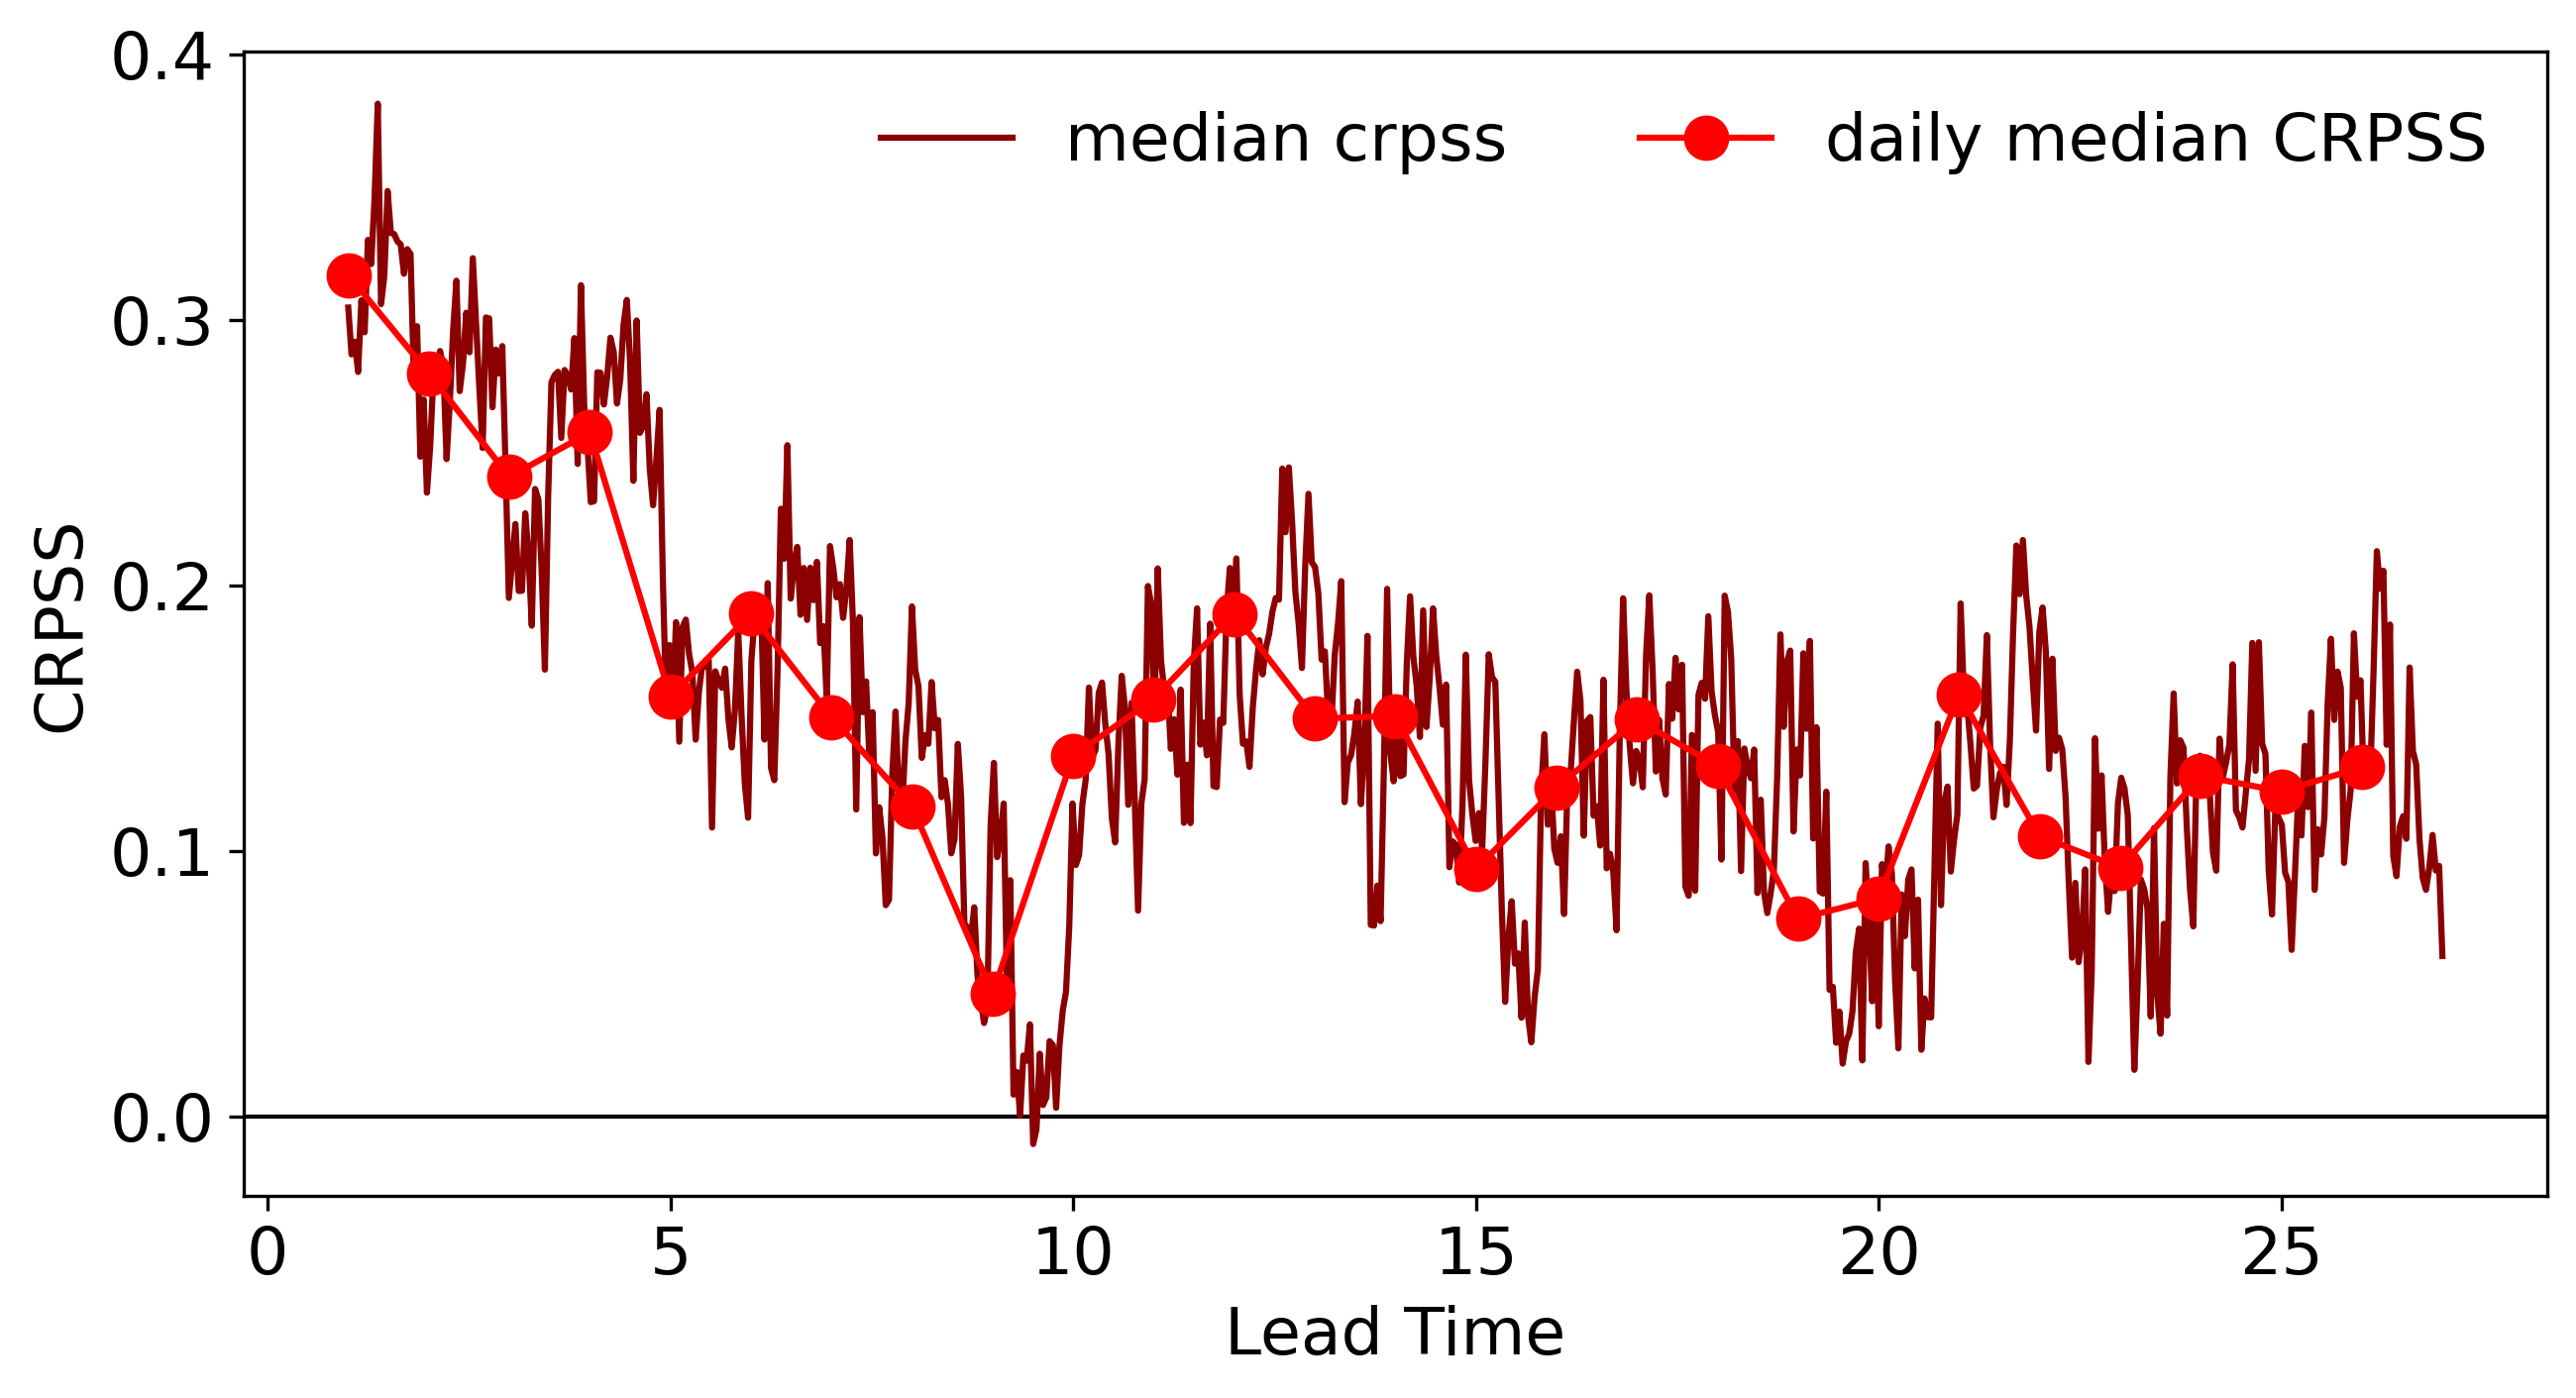

In [31]:
crpss_sets = []
for df_ in daily_ensemble_sets:
    crpss_sets.append(df_['crpss'].iloc[0:640])

lead_time_axis = np.linspace(1,max_lead_time,640)

crpss_mean = []
crpss_median = []
for i in range(max_lead_time):
    index = (lead_time_axis > i+1) & (lead_time_axis < (i+2))
    crpss_mean.append(np.nanmean([crpss[index] for crpss in crpss_sets]))
    crpss_median.append(np.nanmedian([crpss[index] for crpss in crpss_sets]))

plt.figure(figsize = (10,5), dpi=300)
plt.axhline(0, lw=1, color='black')
#plt.plot(lead_time_axis, np.nanmean(crpss_sets, axis=0), color='navy', label='mean crpss')
plt.plot(lead_time_axis, np.nanmedian(crpss_sets, axis=0), color='darkred', label = 'median crpss')
#plt.plot(np.linspace(1,10, len(crpss_mean)), crpss_mean, marker='o', markersize = 10, color='blue', label = 'daily mean CRPSS')
plt.plot(np.linspace(1,max_lead_time, len(crpss_median)), crpss_median, marker='o', markersize = 10, color='red', label = 'daily median CRPSS')
#plt.ylim(-0.4,0.3)
plt.ylabel('CRPSS')
plt.xlabel('Lead Time')
plt.legend(frameon=False, ncols=2)
plt.show()

### Evaluating by $\sigma_{longitude}$


In [32]:
def crps_ensemble_evaluation(daily_ensemble_sets):

    #evaluate crps for each ensemble by timestep 
    for df_ in daily_ensemble_sets:
        crps_list = np.array([crps_discrete(df_.iloc[i].filter(like='vsw'), df_.iloc[i]['observation']) for i in range(df_.shape[0])])
        df_['crps'] = crps_list # add evaluations as a column in ensemble dataframe

        #evaluate climatology and skill score for each ensemble 
        crps_climate = np.array([crps_discrete(climatology, df_.iloc[i]['observation']) for i in range(df_.shape[0])])
        df_['crps_climate'] = crps_climate # add evaluations as a column in ensemble dataframe#
        df_['crpss'] = 1 - (df_['crps']/df_['crps_climate'])

    return


In [33]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 5 # degrees
#sigma_longitude = 7 # degrees
year_str = '2023'
gen_dist = '_fullrot'

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)

longitudes_to_test = [0,5,10,15,20]
#latitudes_to_test = [0,5,10,15,20]

daily_crpss_across_longitude = []
cont_crpss_across_longitude = []

#for sigma_latitude in latitudes_to_test:
for sigma_longitude in longitudes_to_test:

    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist)
    climatology = df_filtered.loc['2023-01':'2023-12']['V'].mean()
    print(sigma_longitude)
    #print(f'Climatological wind speed = {climatology:.3f} km/s')

    crps_ensemble_evaluation(daily_ensemble_sets)

    crpss_sets = []
    for df_ in daily_ensemble_sets:
        crpss_sets.append(df_['crpss'].iloc[0:238])

    lead_time_axis = np.linspace(1,10,238)

    #crpss_mean = []
    crpss_daily_median = []
    for i in range(10):
        index = (lead_time_axis > i+1) & (lead_time_axis < (i+2))
        #crpss_mean.append(np.nanmean([crpss[index] for crpss in crpss_sets]))
        crpss_daily_median.append(np.nanmedian([crpss[index] for crpss in crpss_sets]))
    
    daily_crpss_across_longitude.append(crpss_daily_median)
    cont_crpss_across_longitude.append(np.nanmedian(crpss_sets, axis=0))


['ens_5_100_wsa_2023_fullrot']
0


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


['ens_5_100_wsa_2023_fullrot']
5


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


['ens_5_100_wsa_2023_fullrot']
10


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


['ens_5_100_wsa_2023_fullrot']
15


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


['ens_5_100_wsa_2023_fullrot']
20


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


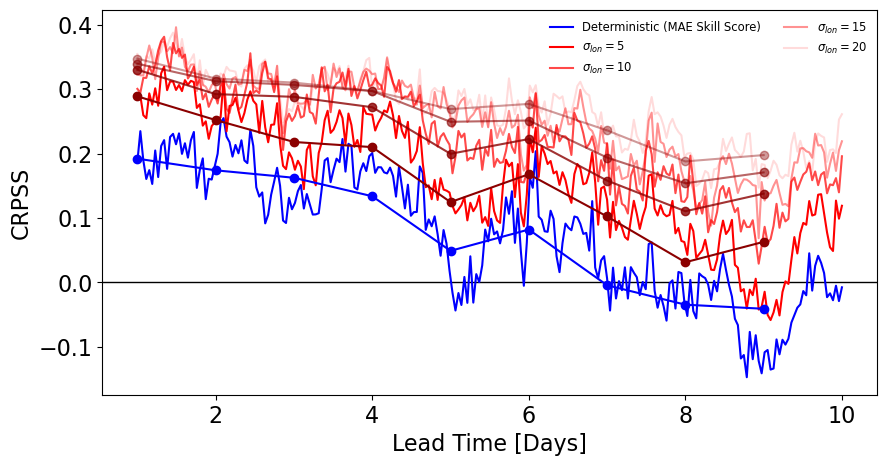

In [35]:

lead_time_axis = np.linspace(1,10,238)

plt.figure(figsize = (10,5))
plt.axhline(0, lw=1, color='black')


plt.plot(np.linspace(1,10,len(cont_crpss_across_longitude[0])), cont_crpss_across_longitude[0], color = 'blue', label = f'Deterministic (MAE Skill Score)')

for i, crpss_med in enumerate(cont_crpss_across_longitude[1:]):
    plt.plot(np.linspace(1,10,len(crpss_med)), crpss_med, color = 'red', alpha = 1-i/3.5, label = f'$\sigma_{{lon}}={longitudes_to_test[i+1]}$')

plt.plot(np.linspace(1,10,len(daily_crpss_across_longitude[0])), daily_crpss_across_longitude[0], color = 'blue', marker = 'o', linestyle='-')

for i, crpss_med in enumerate(daily_crpss_across_longitude[1:]):
    plt.plot(np.linspace(1,10,len(crpss_med)), crpss_med, color = 'darkred', alpha = 1-i/5, marker = 'o', linestyle='-')#, label = f'$\sigma_{{lon}}={longitudes_to_test[i]}$')


plt.legend(frameon = False, ncols=2, fontsize = 'small')
plt.ylabel('CRPSS')
plt.xlabel('Lead Time [Days]')


filename = "CRPSS_2023_across_lon.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_01\\{filename}"
#plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')



plt.show()


### Cost Loss Analysis

In [36]:
def finding_cost_loss(actual_events, forecasted_probabilities, threshold):
    """
    Finding costs and loss based on an action threshold.

    Parameters:
    actual_events (boolean array): List of actual events (True for event occurred, False otherwise).
    forecasted_probabilities (array): List of forecasted probabilities for events.
    threshold (float): Threshold for action.

    Returns:
    dict: Dictionary containing counts for correct forecasts, incorrect forecasts, and missed events.
    """
    correct_forecasts = 0
    incorrect_forecasts = 0
    missed_events = 0

    for actual, probability in zip(actual_events, forecasted_probabilities):
        if actual and probability >= threshold: # correctly forecast event (incurring a cost)
            correct_forecasts += 1
        elif not actual and probability >= threshold: # incoreectly forecast event (incurring a cost)
            incorrect_forecasts += 1
        elif actual and probability < threshold: # missing an event (incurring a loss)
            missed_events += 1
    
    return {'correct_costs': correct_forecasts, 'incorrect_costs': incorrect_forecasts, 'loss': missed_events}


def calculate_potential_economic_value(actual_events, costs, losses, cost_loss_ratio):

    """
    Finding potenial economic value

    Parameters:
    actual_events (boolean array): List of actual events (True for event occurred, False otherwise).
    costs (float): number of costs
    losses (float): number of losses
    cost_loss_ratio (float): cost loss ratio for computing potential economic value

    Returns:
    V: potential economic value
    """
        
    climatology_prob = np.mean(actual_events)
    #climatology_prob = 0.25
    perfect_cost = np.sum(actual_events)

    # climatological cost changes if climatological prob is above/below c/l ratio 
    if cost_loss_ratio <= climatology_prob: # always take action

        climatological_cost = len(actual_events)
        climatological_expense = climatological_cost*cost_loss_ratio
    
        #climatological_expense = len(action_threshold_data)*cost_loss_ratio

    elif cost_loss_ratio > climatology_prob: # never take action

        climatological_loss = perfect_cost
        climatological_expense = climatological_loss

    # forecast expense
    forecast_expense = costs*cost_loss_ratio + losses

    # potential economic value
    V = 100 * ((climatological_expense - forecast_expense)/(climatological_expense - perfect_cost*cost_loss_ratio))

    return V


In [68]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 15 # degrees
sigma_longitude = 10
year_str = '2023'

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)

daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date)

In [13]:
max_lead_time = 10

# intialise and prepare dictionary to collate forecast lead time sets
lead_time_dict = {}
for i in range(max_lead_time):
    lead_time_dict.update({f'{i+1}_day_lead':[]})

for df_ in daily_ensemble_sets:

    # start time from index
    init_time = df_.index[0]
    day_dt = pd.Timedelta(days=1)

    # loop through lead times and chunk up ensembles by lead time adding to lead time dictionary
    for i in range(max_lead_time):
        lead_time_dict[f'{i+1}_day_lead'].append(df_.loc[init_time+(day_dt*i):init_time+(day_dt*(i+1))])


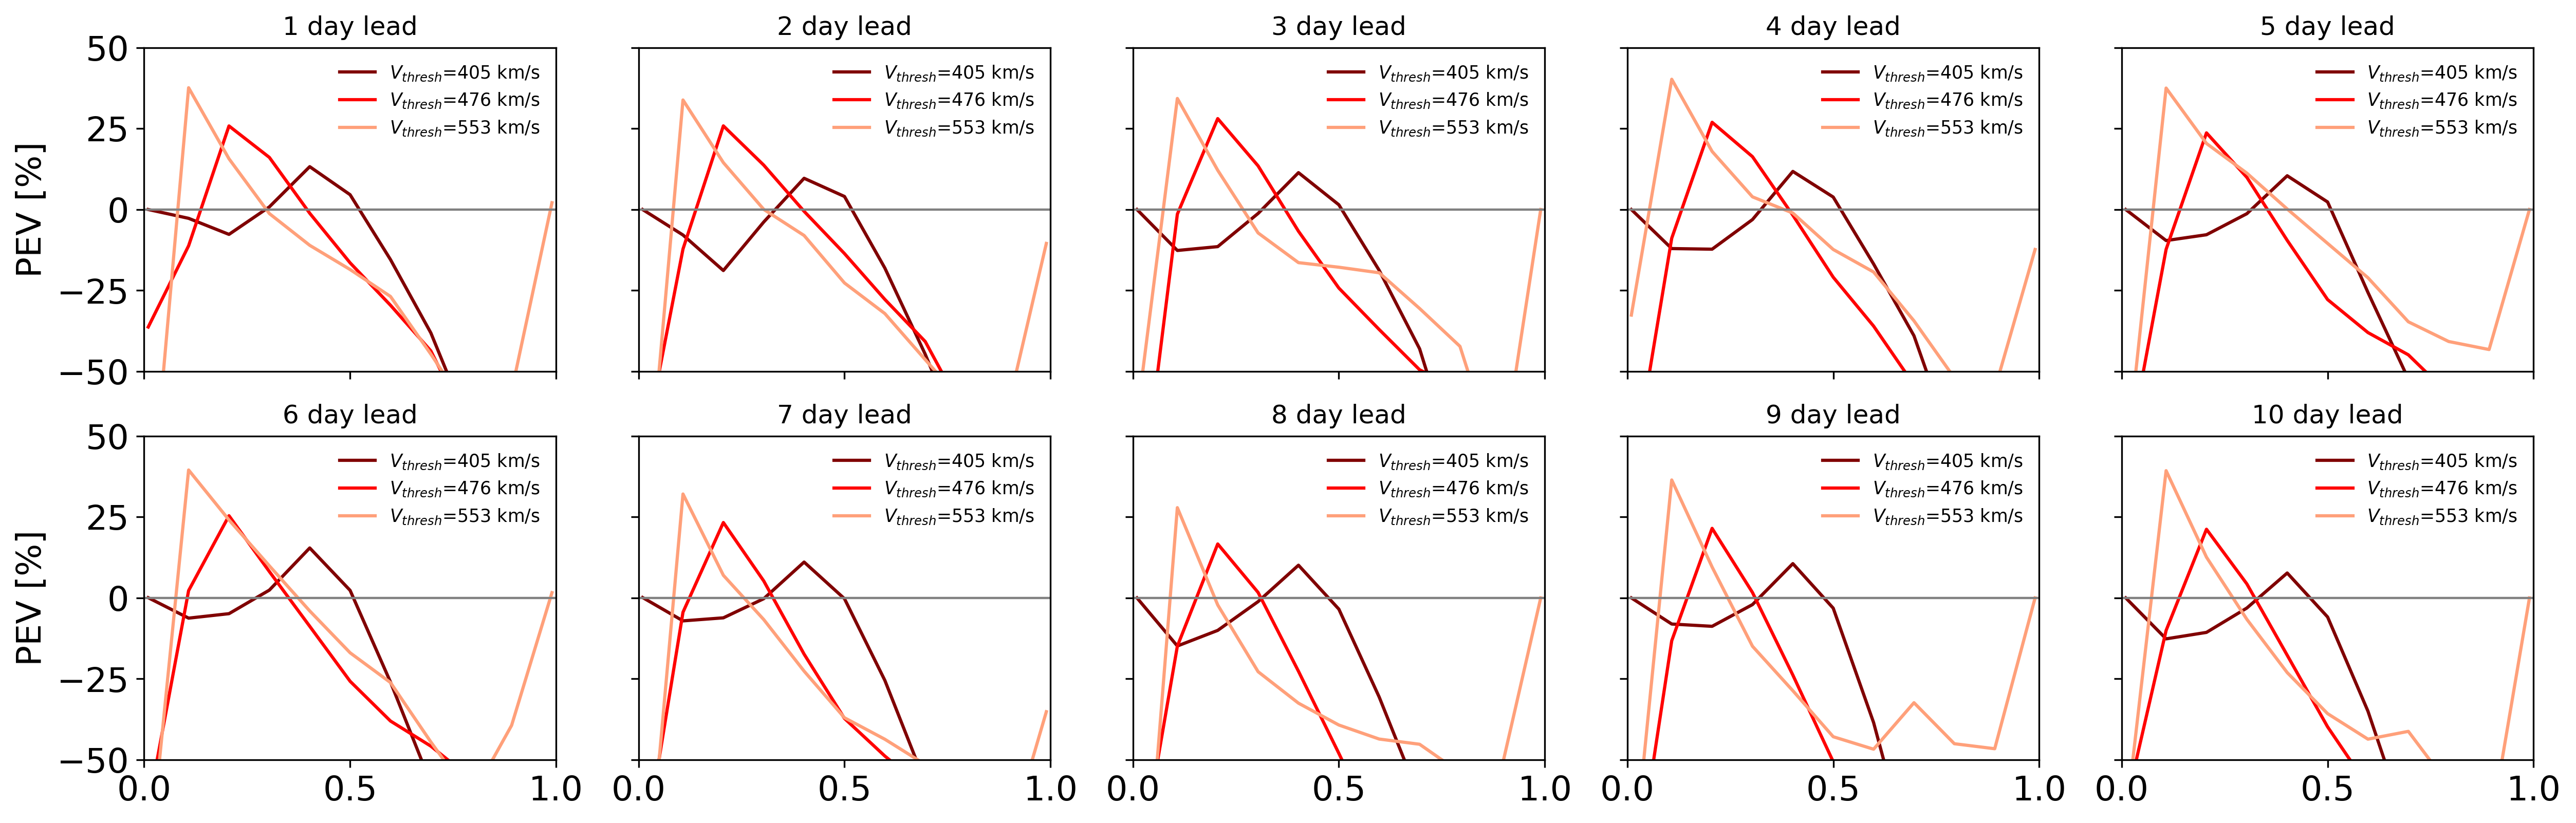

In [59]:
# Define cost/loss bins
cost_loss_ratios = np.linspace(0.01,0.99,11)

# Action thresholds for cost/loss
action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 50), np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 75), np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 90)]
color_thresh = ['maroon', 'red', 'lightsalmon']
max_lead_time = 10

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,6), sharey = True, dpi=300, sharex = True)
axes = axes.flatten()

#axes = plt.subplot(gs[0])

for i in range(max_lead_time):
    
    df_ = pd.concat(lead_time_dict[f'{i+1}_day_lead']).copy()

    for action_threshold in action_thresholds:
        df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

    # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
  

    for j, action_threshold in enumerate(action_thresholds):

        probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
        action_threshold_data = df_['observation'] > action_threshold

        # loop through cost/loss ratios
        PEV_list = []
        for cl in cost_loss_ratios:
            
            # set cl ratio as probability threshold
            prob_thresh = cl
            # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
            ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
            PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                        losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
        
        axes[i].plot(cost_loss_ratios, PEV_list, label = f'$V_{{thresh}}$={int(action_threshold)} km/s', color = color_thresh[j])
        axes[i].legend(frameon = False, fontsize = 'small')
        axes[i].axhline(0, lw = 1, color = 'grey')
        axes[i].set_xlim(0,1)
        axes[i].set_xticks([0,0.5,1])
        axes[i].set_title(f'{i+1} day lead')

axes[i].set_ylim(-50,50)


axes[0].set_ylabel('PEV [%]')
axes[5].set_ylabel('PEV [%]')

# fname = 'Cost_Loss_Calibrated_Comparison.svg'
# path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_05\\{fname}'
# plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

0
5
10
15


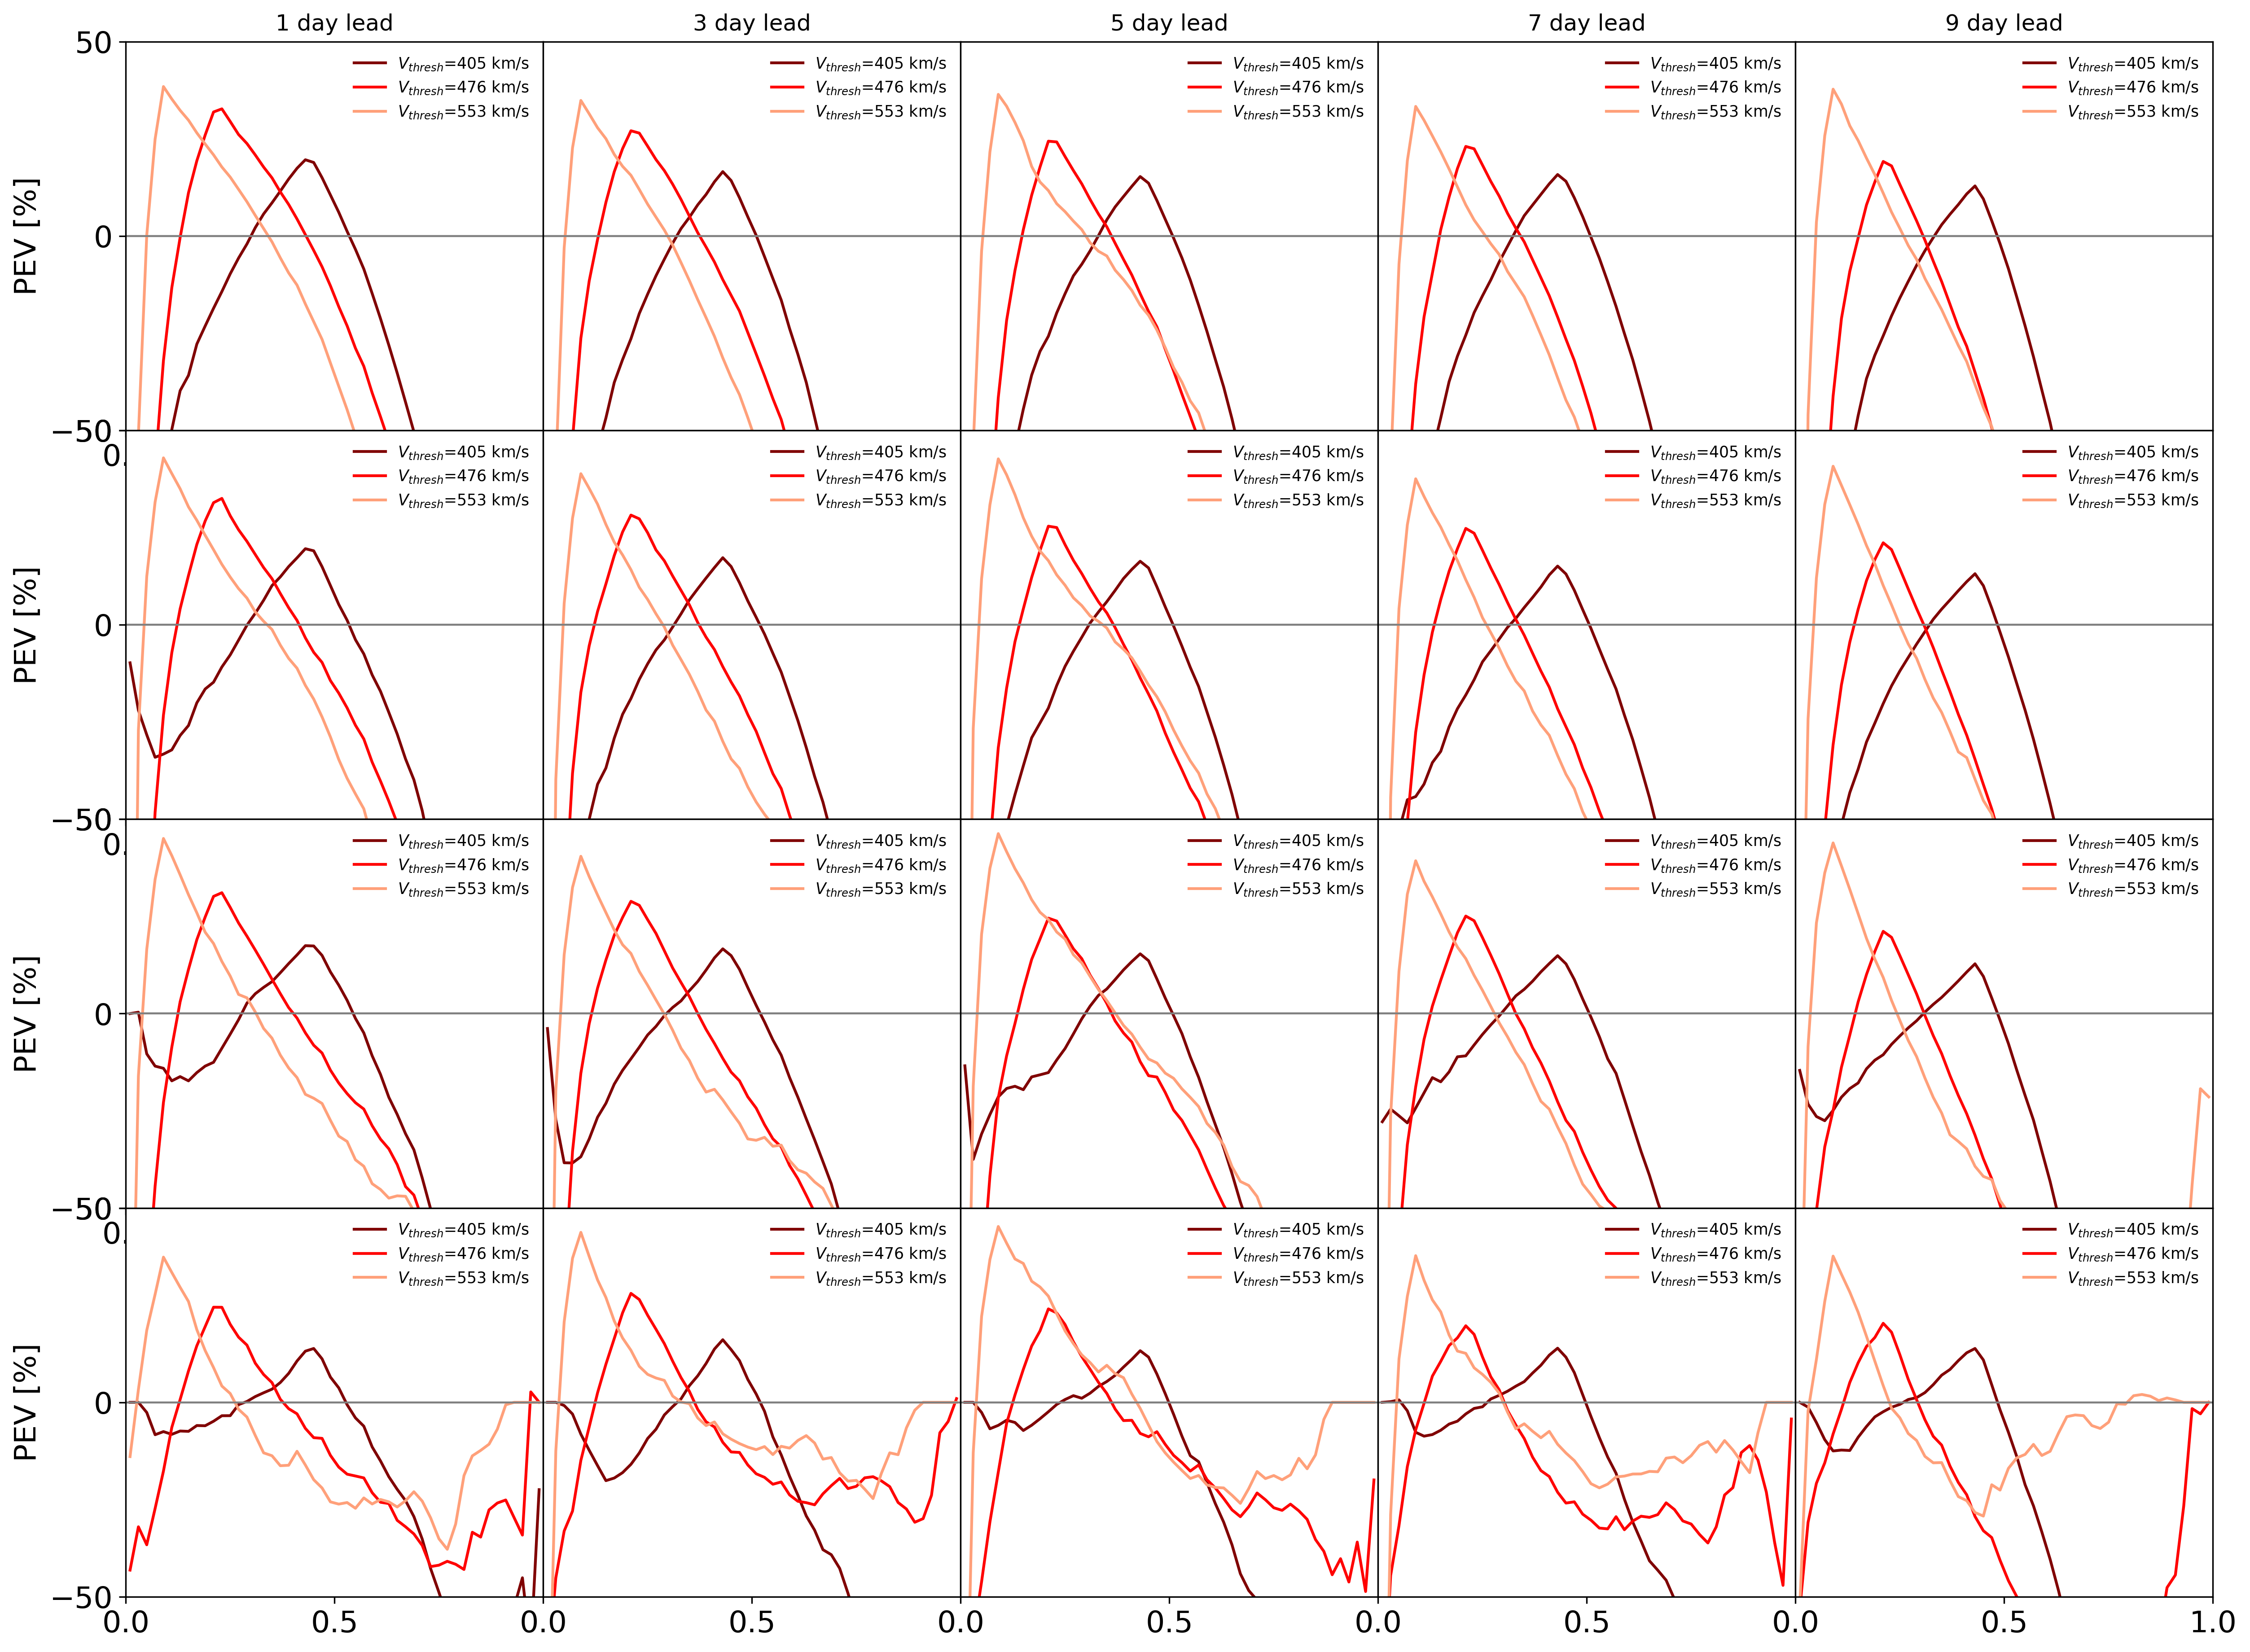

In [15]:
ensemble_size = 100
#sigma_latitudes = [5,10,20,30] # degrees
sigma_latitude = 10
#sigma_longitude = 5
sigma_longitudes = [0,5,10,20]
year_str = '2023'

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)

fig = plt.figure(figsize = (20,15), dpi=300)
gs = grd.GridSpec(4, 5, height_ratios=[5,5,5,5], width_ratios=[5,5,5,5,5], wspace=0.0, hspace=0.0)
plot_idx = 0

for sigma_longitude in  sigma_longitudes:
    print(plot_idx)
    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date)

    max_lead_time = 10

    # intialise and prepare dictionary to collate forecast lead time sets
    lead_time_dict = {}
    for i in range(max_lead_time):
        lead_time_dict.update({f'{i+1}_day_lead':[]})

    for df_ in daily_ensemble_sets:

        # start time from index
        init_time = df_.index[0]
        day_dt = pd.Timedelta(days=1)

        # loop through lead times and chunk up ensembles by lead time adding to lead time dictionary
        for k in range(max_lead_time):
            lead_time_dict[f'{k+1}_day_lead'].append(df_.loc[init_time+(day_dt*k):init_time+(day_dt*(k+1))])

    # Define cost/loss bins
    cost_loss_ratios = np.linspace(0.01,0.99,50)

    # Action thresholds for cost/loss
    action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 50), np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 75), np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 90)]
    color_thresh = ['maroon', 'red', 'lightsalmon']
    max_lead_time = 10

    for i, ii in enumerate([0,2,4,6,8]):
        
        df_ = pd.concat(lead_time_dict[f'{ii+1}_day_lead']).copy()

        for action_threshold in action_thresholds:
            df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

        # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
        for j, action_threshold in enumerate(action_thresholds):

            probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
            action_threshold_data = df_['observation'] > action_threshold

            # loop through cost/loss ratios
            PEV_list = []
            for cl in cost_loss_ratios:
                
                # set cl ratio as probability threshold
                prob_thresh = cl
                # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
                ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
                PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                            losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
            
            ax = plt.subplot(gs[plot_idx+i])
            ax.plot(cost_loss_ratios, PEV_list, label = f'$V_{{thresh}}$={int(action_threshold)} km/s', color = color_thresh[j])
            ax.legend(frameon = False, fontsize = 'small')
            ax.axhline(0, lw = 1, color = 'grey')
            ax.set_xlim(0,1)
            ax.set_xticks([0,0.5])
            
            ax.set_ylim(-50,50)
            ax.set_yticks([])

    
    ax = plt.subplot(gs[plot_idx])
    ax.set_ylabel('PEV [%]')
    ax.set_yticks([-50,0,50])
    plot_idx += 5


for jj, plot_idx in enumerate([0,2,4,6,8]):
    ax = plt.subplot(gs[jj])
    ax.set_title(f'{plot_idx+1} day lead')


ax = plt.subplot(gs[-1])
ax.set_xticks([0,0.5,1])
plt.show()


# fname = 'Cost_Loss_Calibrated_Comparison.svg'
# path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_05\\{fname}'
# plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')


In [37]:

def split_into_lead_time_sections(max_lead_time, daily_ensemble_sets):

    # intialise and prepare dictionary to collate forecast lead time sets
    lead_time_dict = {}
    for i in range(max_lead_time):
        lead_time_dict.update({f'{i+1}_day_lead':[]})

    for df_ in daily_ensemble_sets:

        # start time from index
        init_time = df_.index[0]
        day_dt = pd.Timedelta(days=1)

        # loop through lead times and chunk up ensembles by lead time adding to lead time dictionary
        for k in range(max_lead_time):
            lead_time_dict[f'{k+1}_day_lead'].append(df_.loc[init_time+(day_dt*k):init_time+(day_dt*(k+1))])

    return lead_time_dict

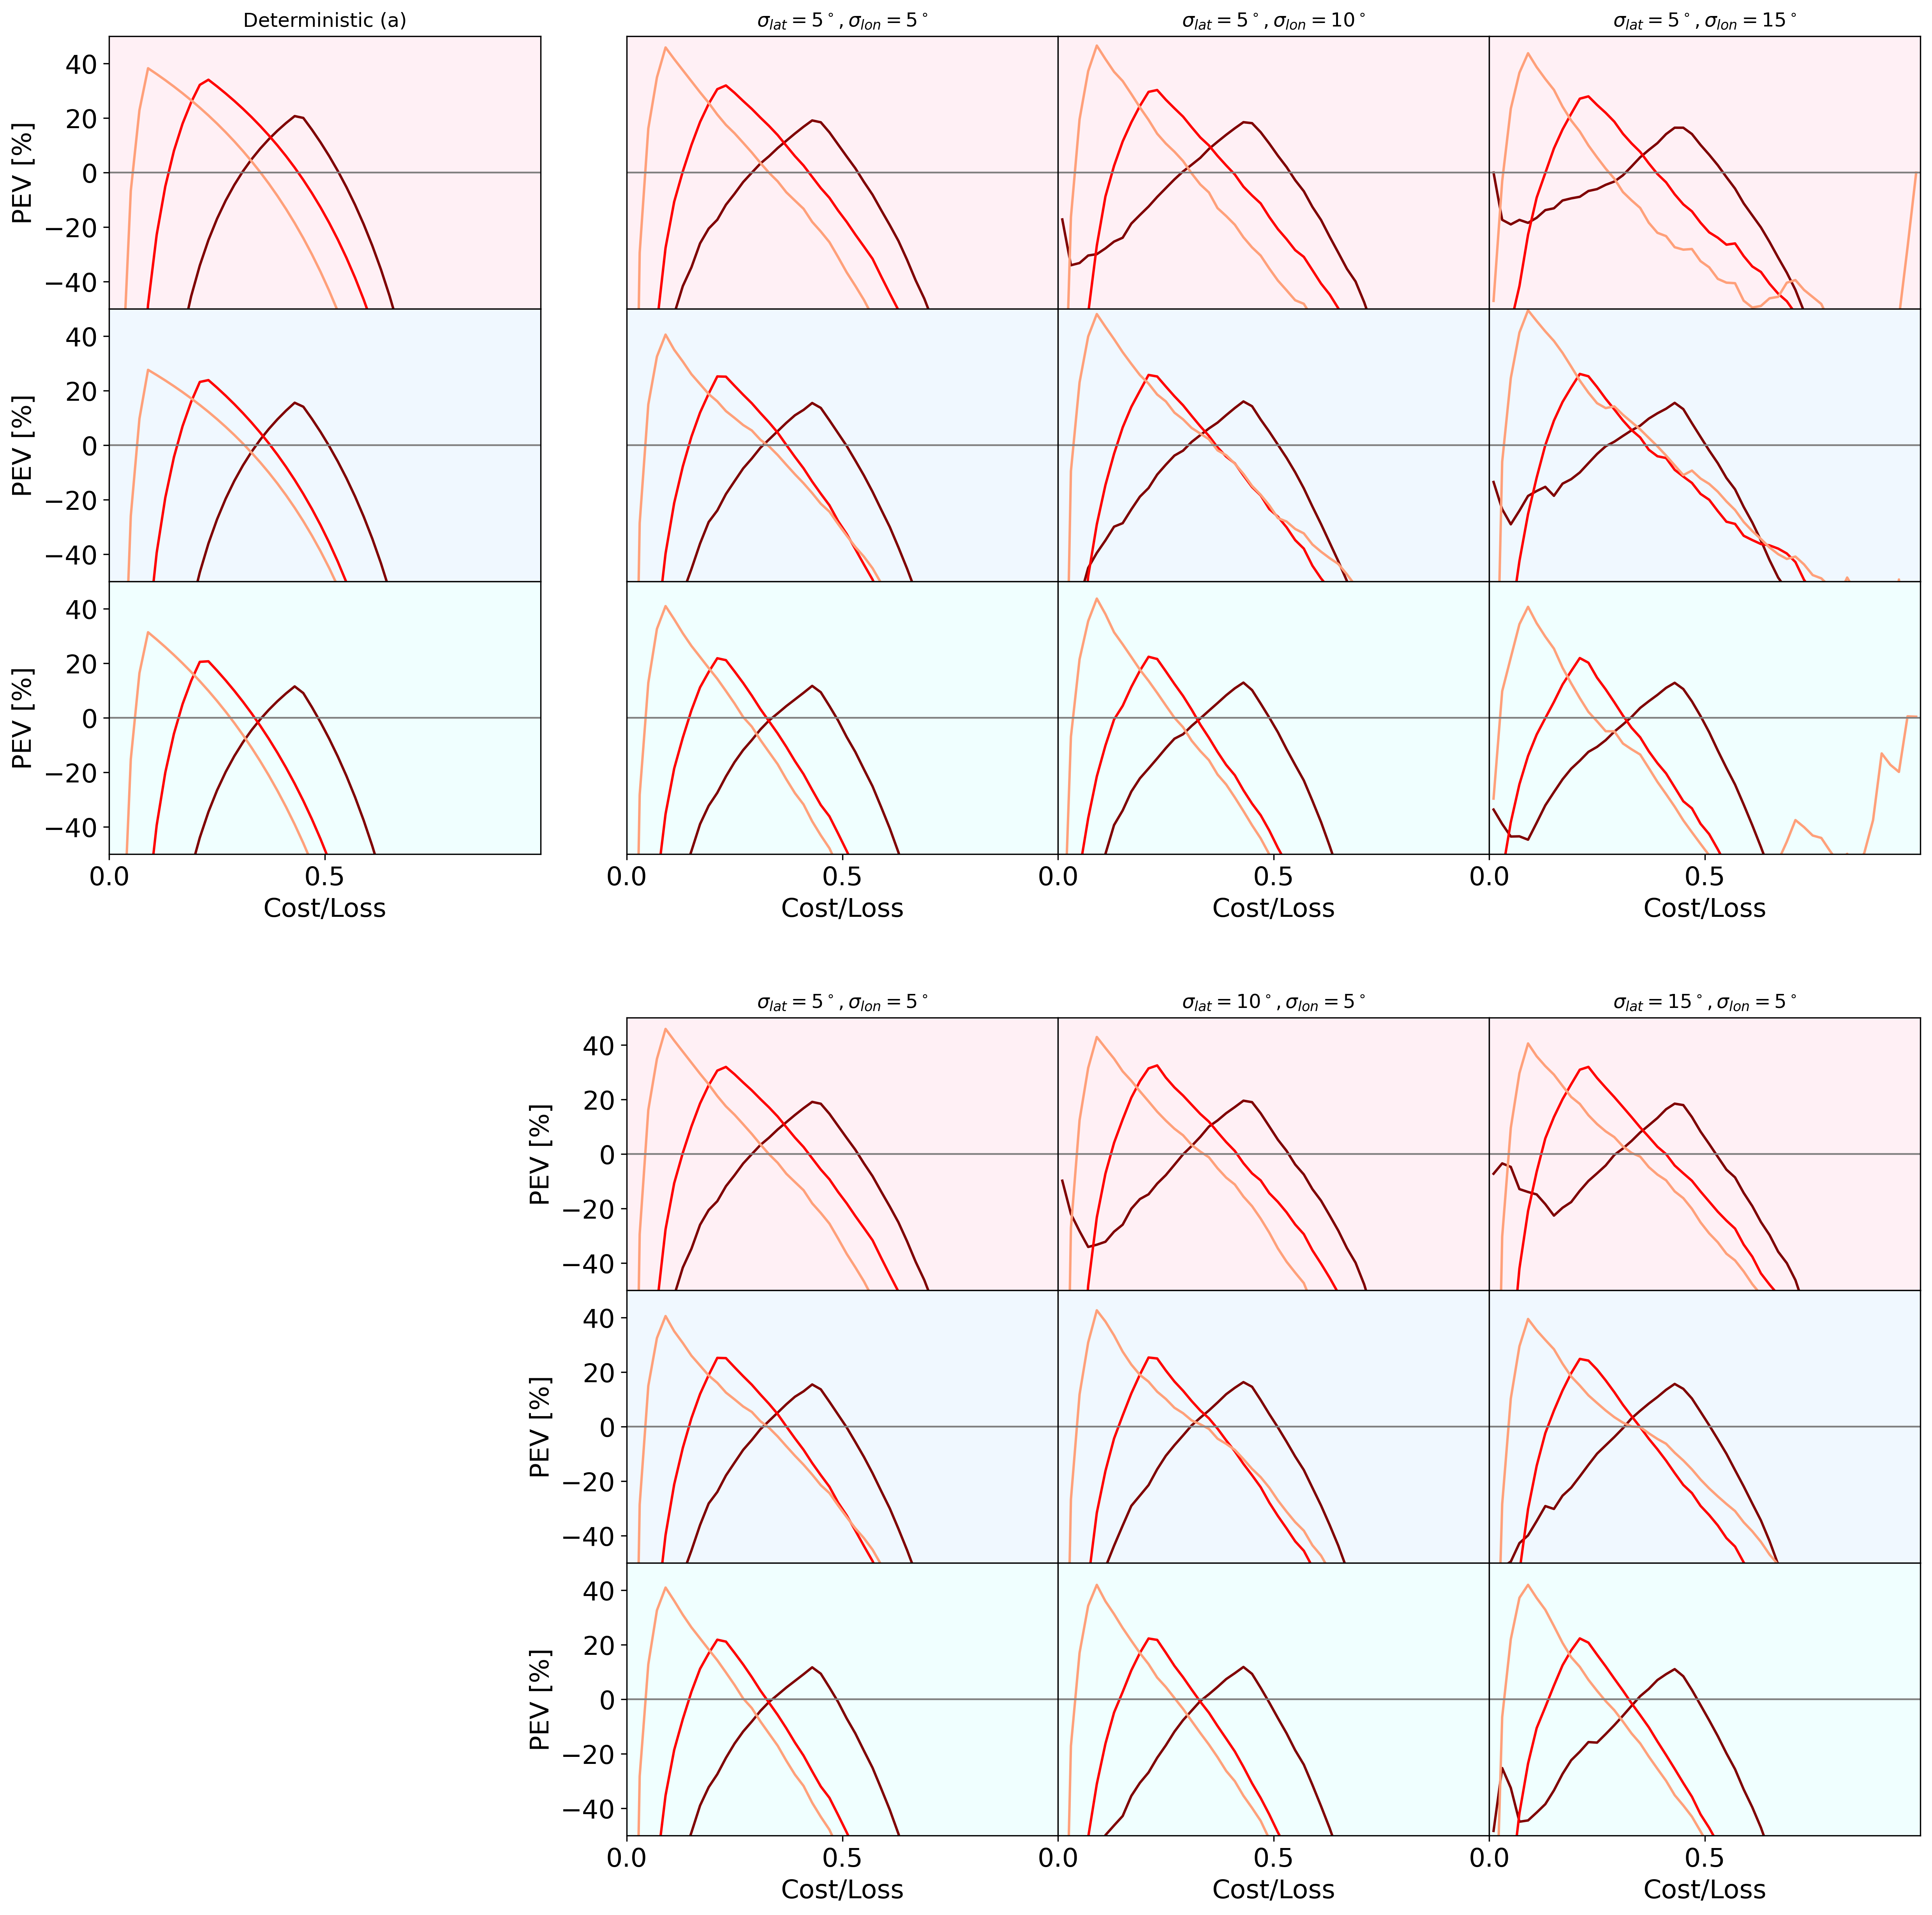

In [106]:
fig = plt.figure(figsize = (20,20), dpi=300)

gs = grd.GridSpec(nrows=7, ncols=5, height_ratios=[5,5,5,3,5,5,5], width_ratios=[5,1,5,5,5], wspace=0.0, hspace=0.0)


# deterministic plot axes
axes_det = [plt.subplot(gs[i]) for i in [0,5,10]]


# specify year + date range of ensembles to load in
year_str = '2023'
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)
daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, 0, 0, year_str, start_date, end_date) # reading in data
lead_time_dict = split_into_lead_time_sections(10, daily_ensemble_sets) # split into chunks by lead time

# Define cost/loss bins
cost_loss_ratios = np.linspace(0.01,0.99,50)
face_color_list = ['lavenderblush','aliceblue','azure']

# Action thresholds for cost/loss
action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 50), np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 75), np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 90)]
color_thresh = ['maroon', 'red', 'lightsalmon']
lead_times_of_interest = [1,5,10] # days

for k, ax in enumerate(axes_det):

    df_ = pd.concat(lead_time_dict[f'{lead_times_of_interest[k]}_day_lead']).copy()

    for action_threshold in action_thresholds:
        df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

    # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
    for j, action_threshold in enumerate(action_thresholds):

        probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
        action_threshold_data = df_['observation'] > action_threshold

        # loop through cost/loss ratios
        PEV_list = []
        for cl in cost_loss_ratios:
            
            # set cl ratio as probability threshold
            prob_thresh = cl
            # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
            ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
            PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                        losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
    
        ax.plot(cost_loss_ratios, PEV_list, label = f'$V_{{thresh}}$={int(action_threshold)} km/s', color = color_thresh[j])
        ax.axhline(0, lw = 1, color = 'grey')
        ax.set_xlim(0,1)
        #ax.set_xticks([0,0.5])
        ax.set_facecolor(face_color_list[k])
        ax.set_ylabel('PEV [%]')
        ax.set_ylim(-50,50)
        ax.set_xticks([])

axes_det[0].set_title('Deterministic (a)')
axes_det[-1].set_xticks([0,0.5])
axes_det[-1].set_xlabel('Cost/Loss')

axes_lat = [plt.subplot(gs[j]) for j in [2,3,4,7,8,9,12,13,14]]

sigma_latitude = 5
sigma_longitudes = [5,10,15]

for m, sigma_longitude in enumerate(sigma_longitudes):
    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date) # reading in data
    lead_time_dict = split_into_lead_time_sections(10, daily_ensemble_sets) # split into chunks by lead time

    action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 50), np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 75), np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 90)]
    color_thresh = ['maroon', 'red', 'lightsalmon']
    lead_times_of_interest = [1,5,10] # days

    for l, ax in enumerate(axes_lat[m::3]):

        df_ = pd.concat(lead_time_dict[f'{lead_times_of_interest[l]}_day_lead']).copy()

        for action_threshold in action_thresholds:
            df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

        # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
        for j, action_threshold in enumerate(action_thresholds):

            probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
            action_threshold_data = df_['observation'] > action_threshold

            # loop through cost/loss ratios
            PEV_list = []
            for cl in cost_loss_ratios:
                
                # set cl ratio as probability threshold
                prob_thresh = cl
                # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
                ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
                PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                            losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
        
            ax.plot(cost_loss_ratios, PEV_list, label = f'$V_{{thresh}}$={int(action_threshold)} km/s', color = color_thresh[j])
            ax.axhline(0, lw = 1, color = 'grey')
            ax.set_xlim(0,1)
            #ax.set_xticks([0,0.5])
            ax.set_yticks([])
            ax.set_facecolor(face_color_list[l])
            ax.set_ylim(-50,50)
            ax.set_xticks([])

for ii in range(3):
    axes_lat[ii].set_title(f'$\sigma_{{lat}}={sigma_latitude}^\\circ,\sigma_{{lon}}={sigma_longitudes[ii]}^\\circ$')

for ii in range(3):
    axes_lat[-ii-1].set_xticks([0,0.5])
    axes_lat[-ii-1].set_xlabel('Cost/Loss')

axes_lon = [plt.subplot(gs[j]) for j in [22,23,24,27,28,29,32,33,34]]

sigma_latitudes = [5,10,15]
sigma_longitude = 5


for m, sigma_latitude in enumerate(sigma_latitudes):
    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date) # reading in data
    lead_time_dict = split_into_lead_time_sections(10, daily_ensemble_sets) # split into chunks by lead time

    action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 50), np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 75), np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 90)]
    color_thresh = ['maroon', 'red', 'lightsalmon']
    lead_times_of_interest = [1,5,10] # days

    for l, ax in enumerate(axes_lon[m::3]):

        df_ = pd.concat(lead_time_dict[f'{lead_times_of_interest[l]}_day_lead']).copy()

        for action_threshold in action_thresholds:
            df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

        # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
        for j, action_threshold in enumerate(action_thresholds):

            probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
            action_threshold_data = df_['observation'] > action_threshold

            # loop through cost/loss ratios
            PEV_list = []
            for cl in cost_loss_ratios:
                
                # set cl ratio as probability threshold
                prob_thresh = cl
                # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
                ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
                PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                            losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
        
            ax.plot(cost_loss_ratios, PEV_list, label = f'$V_{{thresh}}$={int(action_threshold)} km/s', color = color_thresh[j])
            ax.axhline(0, lw = 1, color = 'grey')
            ax.set_xlim(0,1)
            #ax.set_xticks([0,0.5])
            ax.set_yticks([])
            ax.set_facecolor(face_color_list[l])
            ax.set_ylim(-50,50)
            ax.set_xticks([])

for jj in range(3):
    axes_lon[jj].set_title(f'$\sigma_{{lat}}={sigma_latitudes[jj]}^\\circ,\sigma_{{lon}}={sigma_longitude}^\\circ$')

for ax in axes_lon[::3]:
    ax.set_ylabel('PEV [%]')
    ax.set_yticks([-40,-20,0,20,40])

for ii in range(3):
    axes_lon[-ii-1].set_xticks([0,0.5])
    axes_lon[-ii-1].set_xlabel('Cost/Loss')

plt.show()


['ens_0_100_wsa_2023_fullrot']
['ens_5_100_wsa_2023_fullrot']
['ens_5_100_wsa_2023_fullrot']
['ens_5_100_wsa_2023_fullrot']
['ens_10_100_wsa_2023_fullrot']
['ens_15_100_wsa_2023_fullrot']
['ens_20_100_wsa_2023_fullrot']


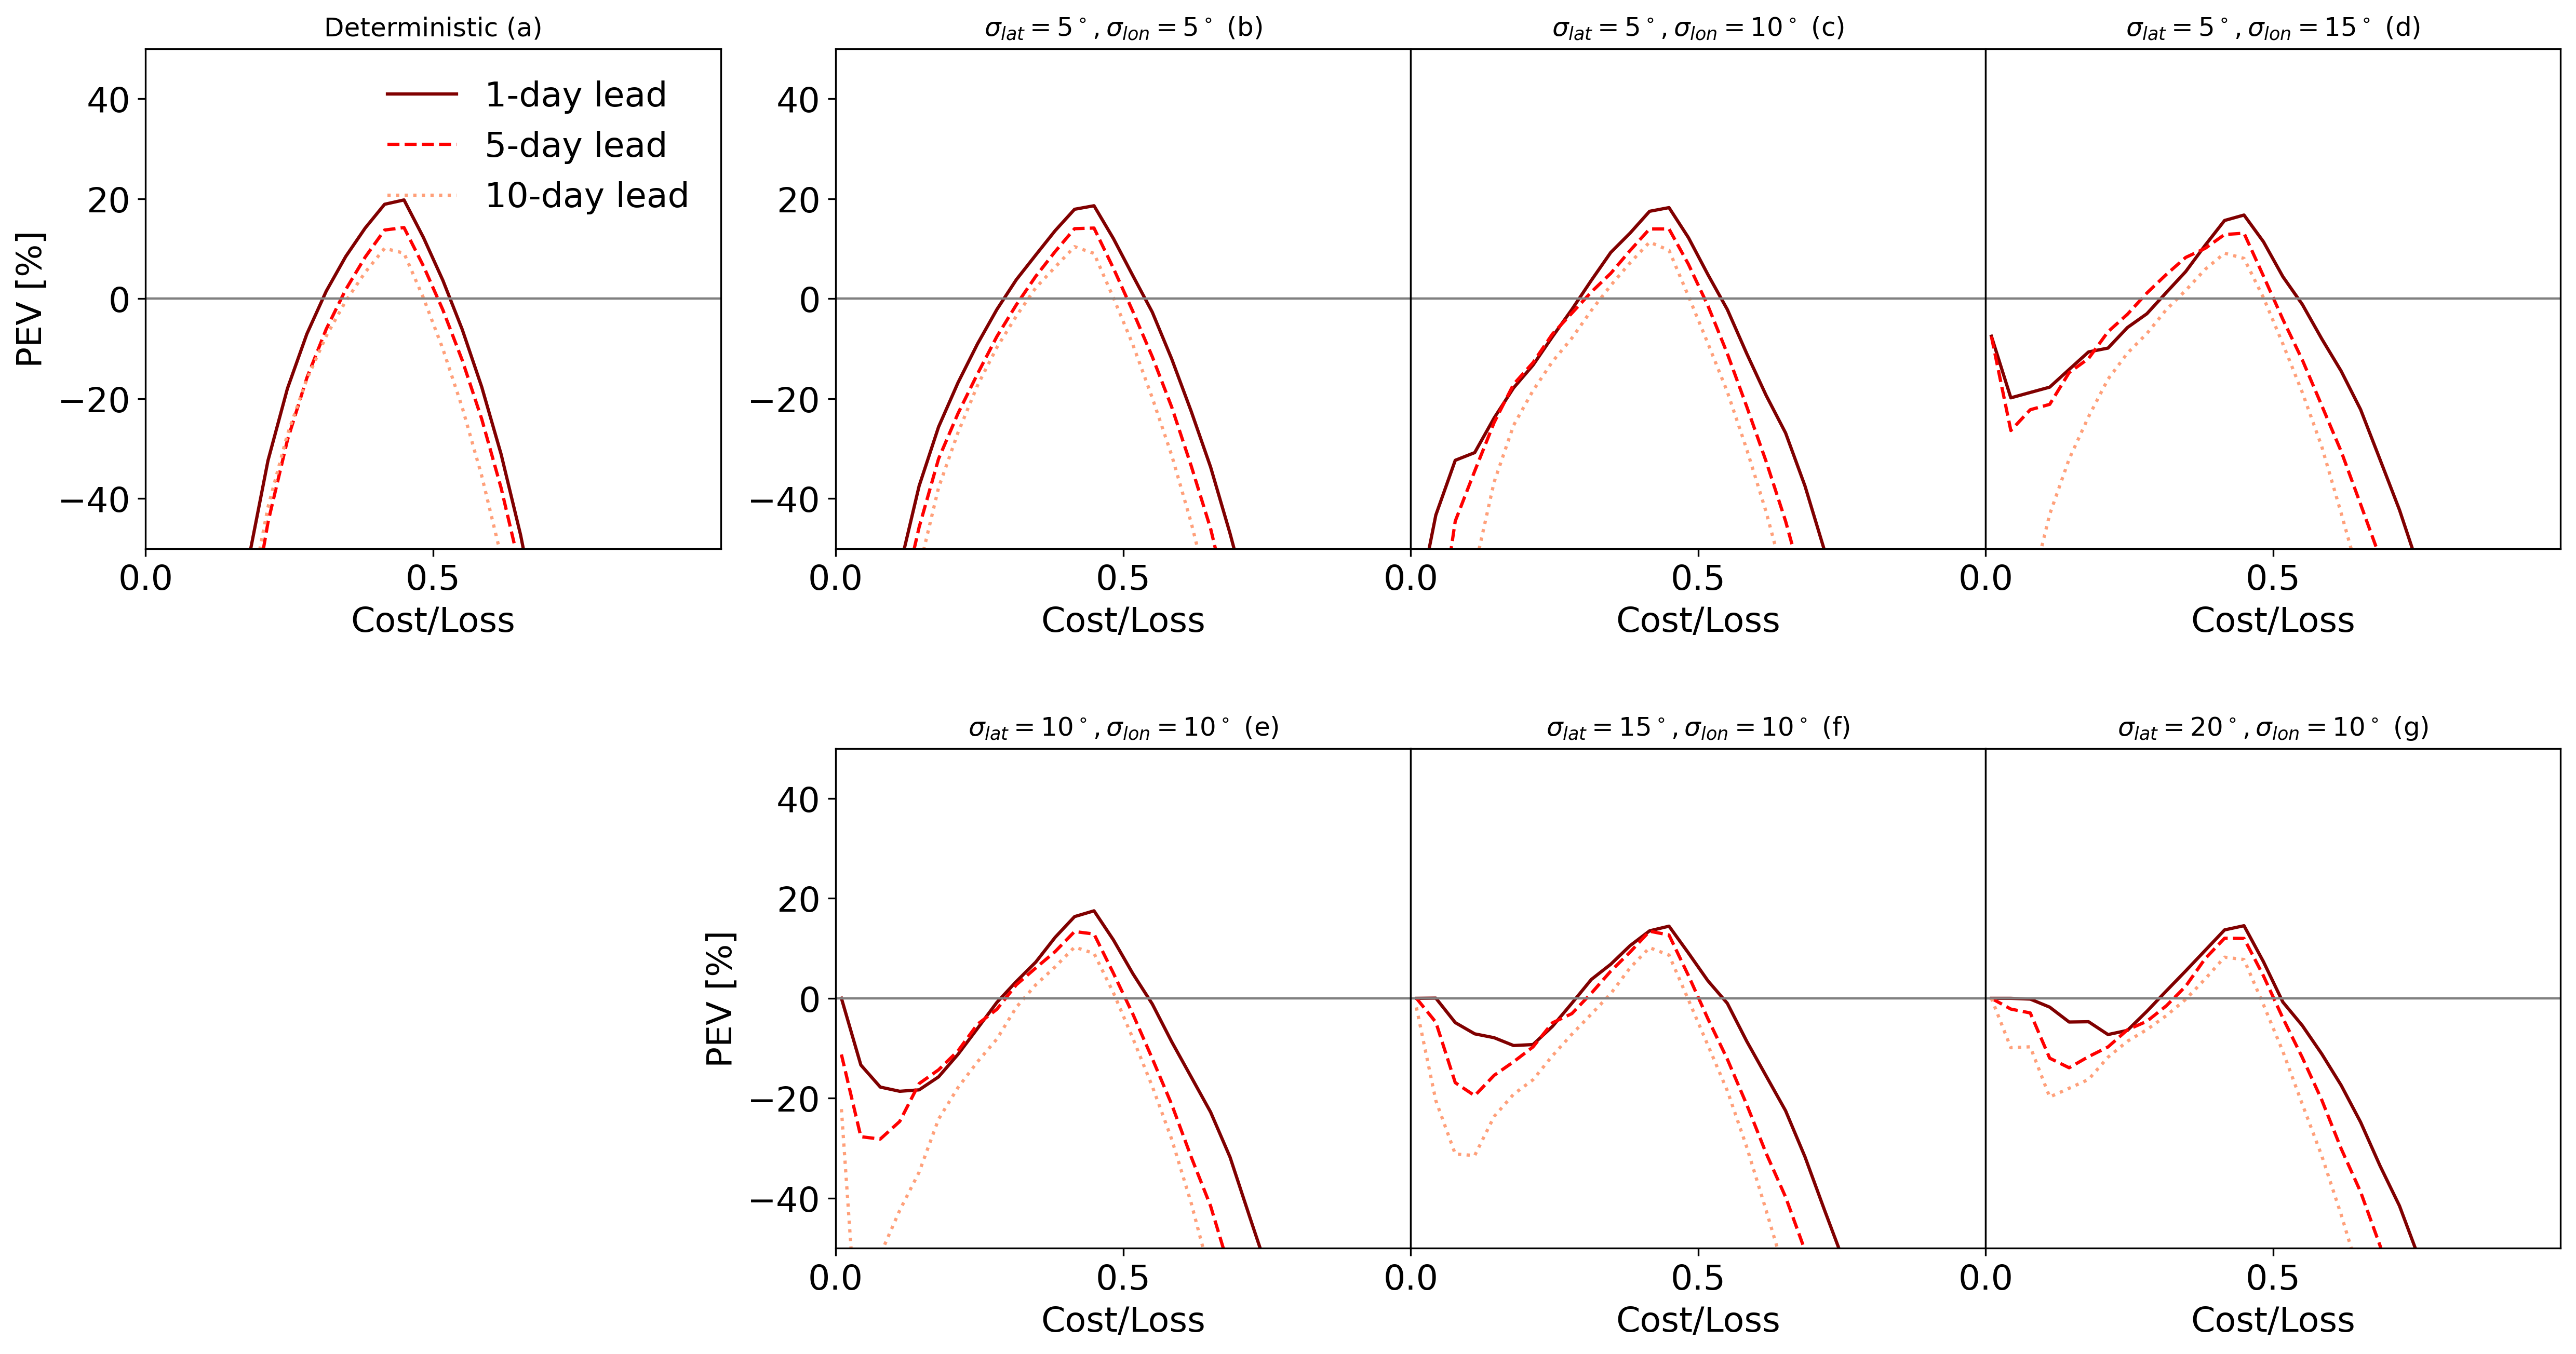

In [40]:
fig = plt.figure(figsize = (20,10), dpi=300)

gs = grd.GridSpec(nrows=3, ncols=5, height_ratios=[5,2,5], width_ratios=[5,1,5,5,5], wspace=0.0, hspace=0.0)

# deterministic plot axes
axes_det = [plt.subplot(gs[i]) for i in [0]]

# specify year + date range of ensembles to load in
year_str = '2023'
gen_dist = '_fullrot'
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)
daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, 0, 0, year_str, start_date, end_date, gen_dist) # reading in data
lead_time_dict = split_into_lead_time_sections(10, daily_ensemble_sets) # split into chunks by lead time
color_thresh = ['maroon', 'red', 'lightsalmon']
# Define cost/loss bins
cost_loss_ratios = np.linspace(0.01,0.99,30)
linestyles = ['-','--',':']

# Action thresholds for cost/loss
action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 50)]
lead_times_of_interest = [1,5,10] # days

for k, _ in enumerate(lead_times_of_interest):
    ax = axes_det[0]
    df_ = pd.concat(lead_time_dict[f'{lead_times_of_interest[k]}_day_lead']).copy()

    for action_threshold in action_thresholds:
        df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

    # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
    for j, action_threshold in enumerate(action_thresholds):

        probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
        action_threshold_data = df_['observation'] > action_threshold

        # loop through cost/loss ratios
        PEV_list = []
        for cl in cost_loss_ratios:
            
            # set cl ratio as probability threshold
            prob_thresh = cl
            # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
            ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
            PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                        losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
    
        ax.plot(cost_loss_ratios, PEV_list, label = f'{lead_times_of_interest[k]}-day lead', color = color_thresh[k], linestyle=linestyles[k])
        ax.axhline(0, lw = 1, color = 'grey')
        ax.set_xlim(0,1)
        #ax.set_xticks([0,0.5])
        ax.set_ylabel('PEV [%]')
        ax.set_ylim(-50,50)
        ax.set_xticks([])

axes_det[0].set_title('Deterministic (a)')
axes_det[-1].set_xticks([0,0.5])
axes_det[-1].set_xlabel('Cost/Loss')
axes_det[0].legend(frameon=False)

axes_lat = [plt.subplot(gs[j]) for j in [2,3,4]]

sigma_latitude = 5
sigma_longitudes = [5,10,15]

for m, sigma_longitude in enumerate(sigma_longitudes):
    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist) # reading in data
    lead_time_dict = split_into_lead_time_sections(10, daily_ensemble_sets) # split into chunks by lead time

    action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 50)]
    color_thresh = ['maroon', 'red', 'lightsalmon']
    lead_times_of_interest = [1,5,10] # days

    for l, _ in enumerate(lead_times_of_interest):
        
        ax = axes_lat[m]

        df_ = pd.concat(lead_time_dict[f'{lead_times_of_interest[l]}_day_lead']).copy()

        for action_threshold in action_thresholds:
            df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

        # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
        for j, action_threshold in enumerate(action_thresholds):

            probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
            action_threshold_data = df_['observation'] > action_threshold

            # loop through cost/loss ratios
            PEV_list = []
            for cl in cost_loss_ratios:
                
                # set cl ratio as probability threshold
                prob_thresh = cl
                # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
                ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
                PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                            losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
        
            ax.plot(cost_loss_ratios, PEV_list, label = f'{lead_times_of_interest[l]}-day lead', color = color_thresh[l], linestyle=linestyles[l])
            ax.axhline(0, lw = 1, color = 'grey')
            ax.set_xlim(0,1)
            ax.set_xticks([0,0.5])
            ax.set_yticks([])
            ax.set_ylim(-50,50)
            ax.set_xticks([])

panel_lat_labels = ['(b)','(c)','(d)']
for ii in range(3):
    axes_lat[ii].set_title(f'$\sigma_{{lat}}={sigma_latitude}^\\circ,\sigma_{{lon}}={sigma_longitudes[ii]}^\\circ$ {panel_lat_labels[ii]}')

for ii in range(3):
    axes_lat[-ii-1].set_xticks([0,0.5])
    axes_lat[-ii-1].set_xlabel('Cost/Loss')

axes_lon = [plt.subplot(gs[j]) for j in [12,13,14]]

sigma_latitudes = [10,15,20]
sigma_longitude = 10

for m, sigma_latitude in enumerate(sigma_latitudes):
    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist) # reading in data
    lead_time_dict = split_into_lead_time_sections(10, daily_ensemble_sets) # split into chunks by lead time

    action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 50)]
    color_thresh = ['maroon', 'red', 'lightsalmon']
    
    lead_times_of_interest = [1,5,10] # days

    for l, _ in enumerate(lead_times_of_interest):
        
        ax = axes_lon[m]

        df_ = pd.concat(lead_time_dict[f'{lead_times_of_interest[l]}_day_lead']).copy()

        for action_threshold in action_thresholds:
            df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

        # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
        for j, action_threshold in enumerate(action_thresholds):

            probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
            action_threshold_data = df_['observation'] > action_threshold

            # loop through cost/loss ratios
            PEV_list = []
            for cl in cost_loss_ratios:
                
                # set cl ratio as probability threshold
                prob_thresh = cl
                # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
                ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
                PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                            losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
        
            ax.plot(cost_loss_ratios, PEV_list, label = f'{lead_times_of_interest[l]}-day lead', color = color_thresh[l], linestyle=linestyles[l])
            ax.axhline(0, lw = 1, color = 'grey')
            ax.set_xlim(0,1)
            ax.set_xticks([0,0.5])
            ax.set_yticks([])
            ax.set_ylim(-50,50)
            ax.set_xticks([])

panel_lon_labels = ['(e)','(f)','(g)']
for jj in range(3):
    axes_lon[jj].set_title(f'$\sigma_{{lat}}={sigma_latitudes[jj]}^\\circ,\sigma_{{lon}}={sigma_longitude}^\\circ$ {panel_lon_labels[jj]}')

#ax.set_ylabel('PEV [%]')
axes_lat[0].set_yticks([-40,-20,0,20,40])

axes_lon[0].set_ylabel('PEV [%]')
axes_lon[0].set_yticks([-40,-20,0,20,40])

for ii in range(3):
    axes_lon[-ii-1].set_xticks([0,0.5])
    axes_lon[-ii-1].set_xlabel('Cost/Loss')



fname = 'cost_loss_2023_50.pdf'
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_01\\{fname}"
plt.savefig(fpath, format = 'pdf', dpi = 300,bbox_inches='tight')


plt.show()


['ens_0_100_wsa_2023_fullrot']
['ens_5_100_wsa_2023_fullrot']
['ens_5_100_wsa_2023_fullrot']
['ens_5_100_wsa_2023_fullrot']
['ens_10_100_wsa_2023_fullrot']
['ens_15_100_wsa_2023_fullrot']
['ens_20_100_wsa_2023_fullrot']


<Figure size 6000x3000 with 0 Axes>

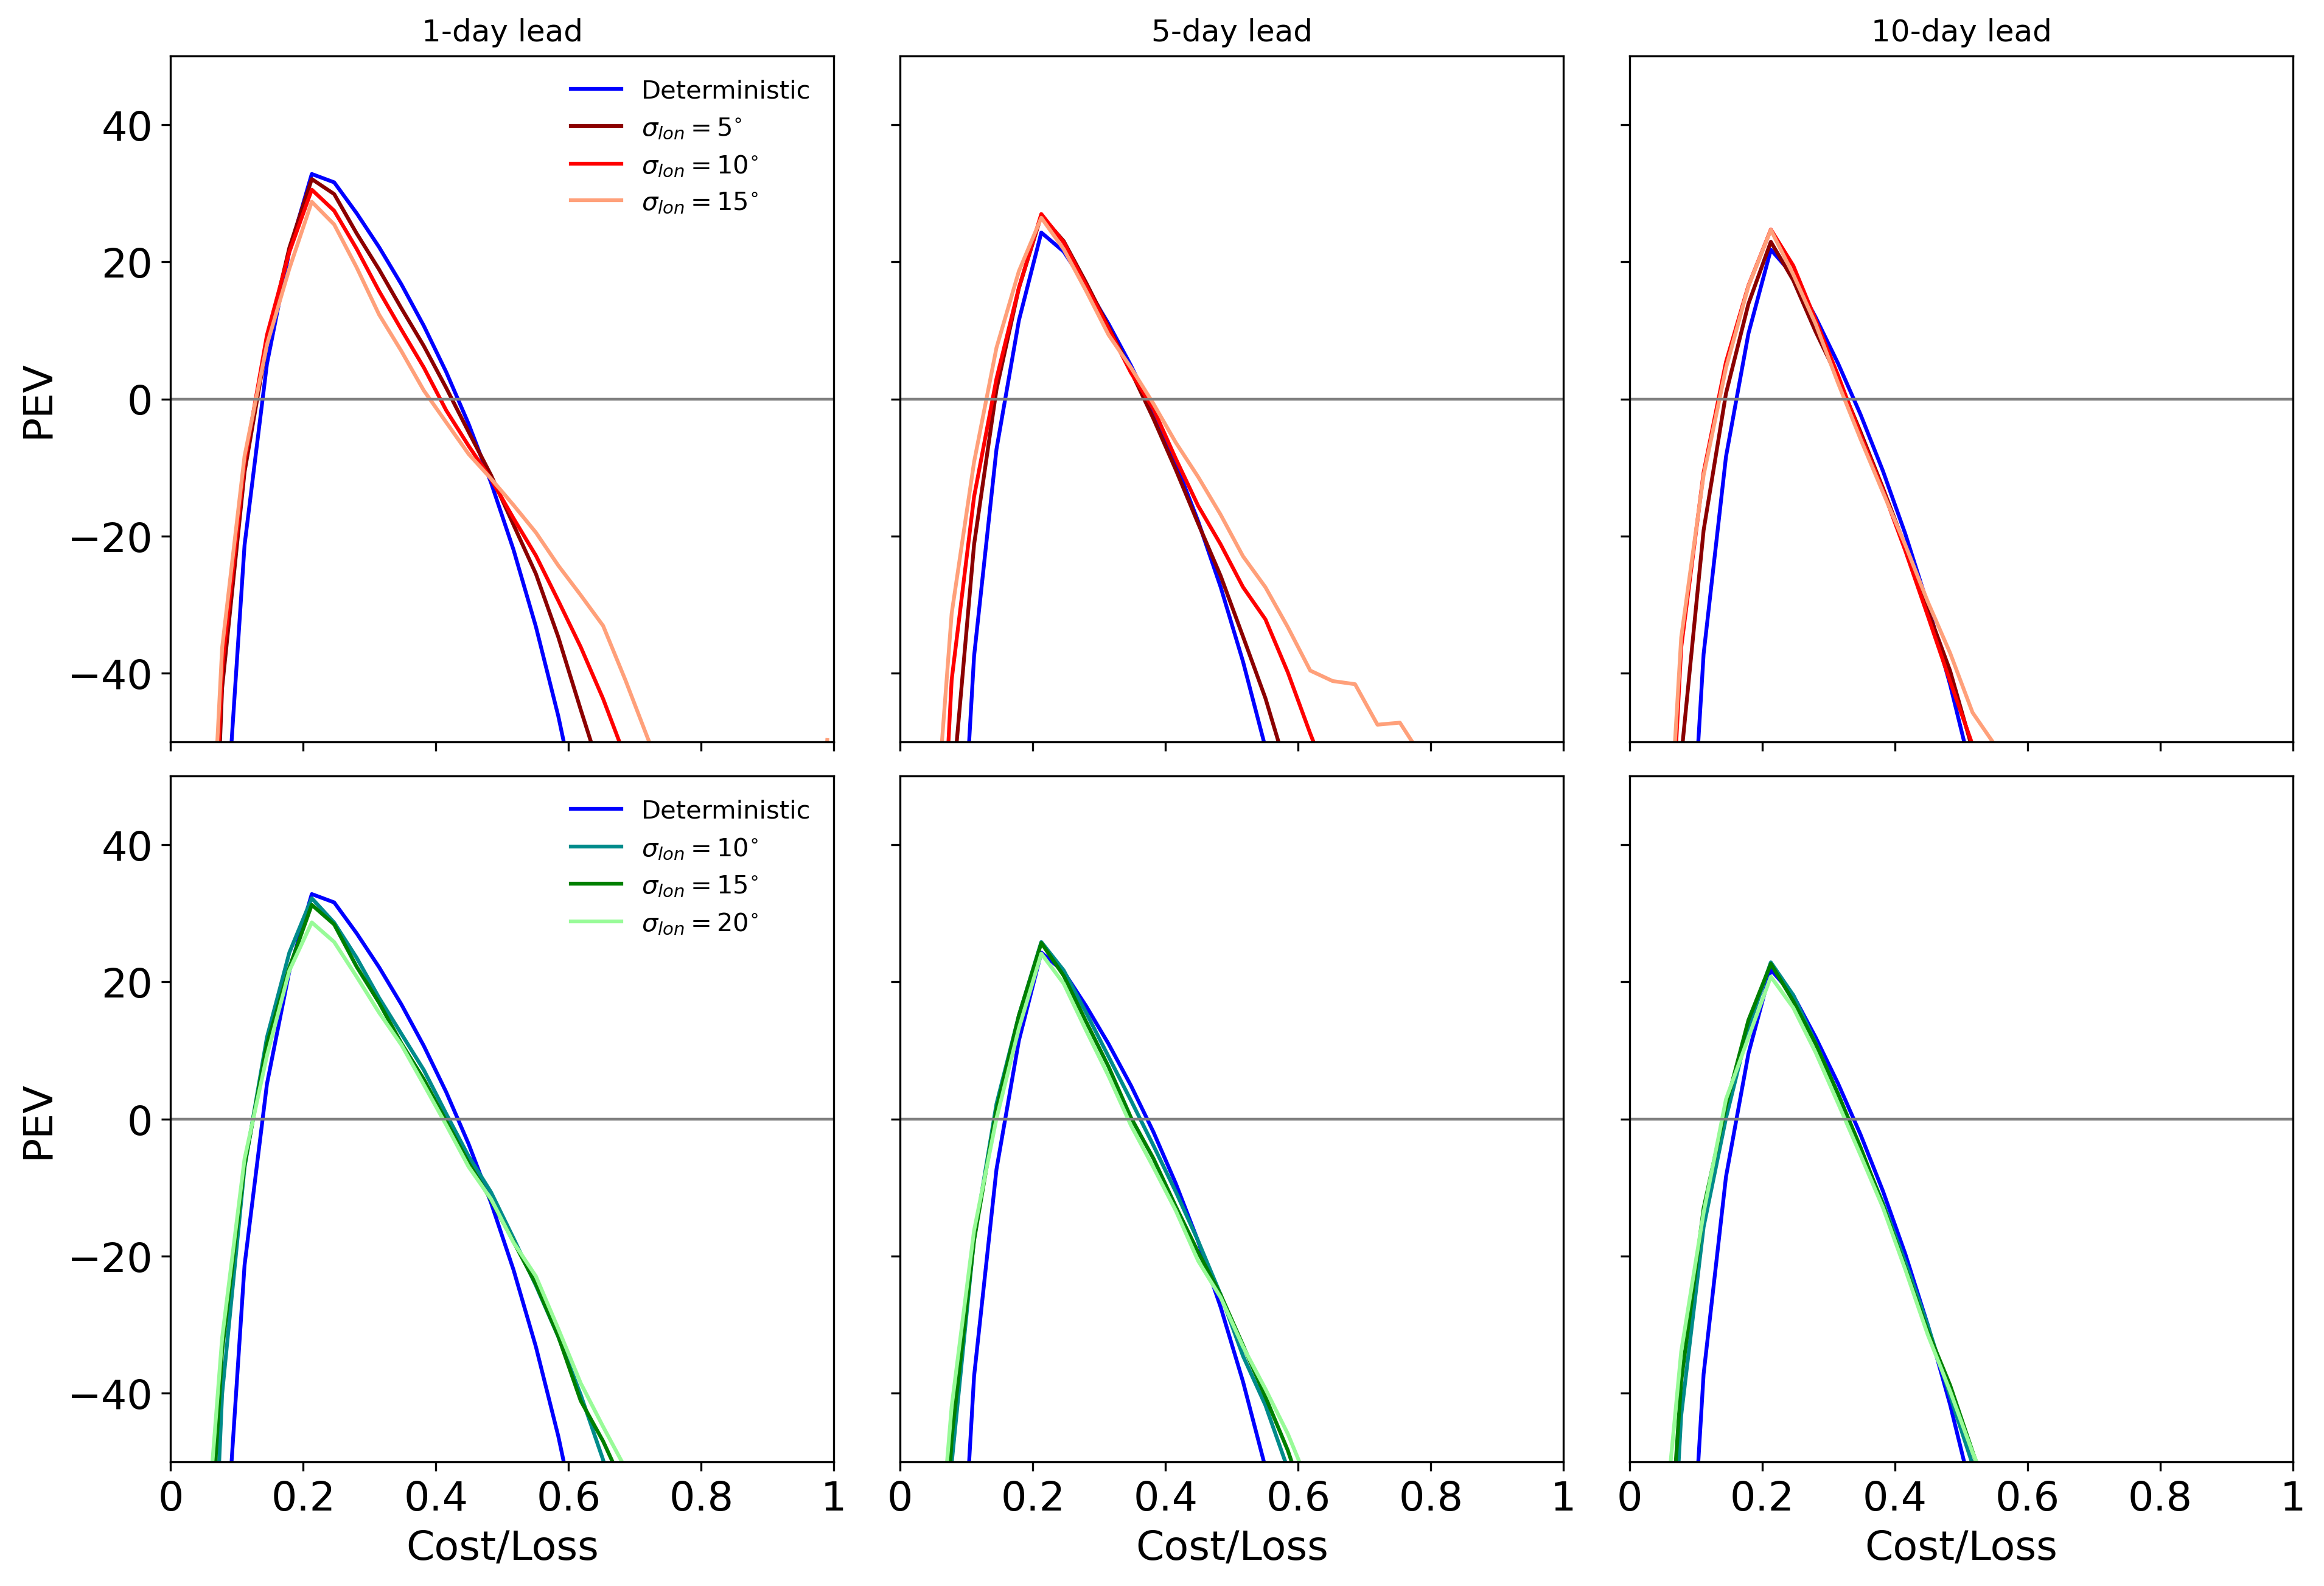

In [46]:
fig = plt.figure(figsize = (20,10), dpi=300)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=300, sharex=True, sharey=True)


# specify year + date range of ensembles to load in
year_str = '2023'
gen_dist = '_fullrot'
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)
deterministic_ensemble_sets = read_daily_ensemble_sets(ensemble_size, 0, 0, year_str, start_date, end_date, gen_dist) # reading in data
deterministic_lead_time_dict = split_into_lead_time_sections(10, deterministic_ensemble_sets) # split into chunks by lead time

# Define cost/loss bins
cost_loss_ratios = np.linspace(0.01,0.99,30)
linestyles = ['-','--',':']

# Action thresholds for cost/loss
action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 75)]
lead_times_of_interest = [1,5,10] # days

for k, lead_time in enumerate(lead_times_of_interest):

    df_ = pd.concat(deterministic_lead_time_dict[f'{lead_time}_day_lead']).copy()

    for action_threshold in action_thresholds:
        df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

    # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
    for j, action_threshold in enumerate(action_thresholds):

        probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
        action_threshold_data = df_['observation'] > action_threshold

        # loop through cost/loss ratios
        PEV_list = []
        for cl in cost_loss_ratios:
            
            # set cl ratio as probability threshold
            prob_thresh = cl
            # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
            ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
            PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                        losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
        
        for ax in axes[:,k]:
            ax.plot(cost_loss_ratios, PEV_list, color = 'blue', label='Deterministic')
            ax.axhline(0, lw = 1, color = 'grey')
            ax.set_xlim(0,1)
            ax.set_ylim(-50,50)
        #ax.set_xticks([0,0.5])
        # ax.set_ylabel('PEV [%]')
            
        # ax.set_xticks([])


for k, ax in enumerate(axes[0,:]):
    ax.set_title(f'{lead_times_of_interest[k]}-day lead')

for k, ax in enumerate(axes[1,:]):
    ax.set_xticks(np.linspace(0,1,6))
    ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1])
    ax.set_xlabel('Cost/Loss')

axes[0,0].set_ylabel('PEV')
axes[1,0].set_ylabel('PEV')

# axes_det[0].set_title('Deterministic (a)')
# axes_det[-1].set_xticks([0,0.5])
# axes_det[-1].set_xlabel('Cost/Loss')
# axes_det[0].legend(frameon=False)

# axes_lat = [plt.subplot(gs[j]) for j in [2,3,4]]

sigma_latitude = 5
sigma_longitudes = [5,10,15]
color_thresh = ['darkred', 'red', 'lightsalmon']

for m, sigma_longitude in enumerate(sigma_longitudes):

    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist) # reading in data
    lead_time_dict = split_into_lead_time_sections(10, daily_ensemble_sets) # split into chunks by lead time

    action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 75)]
    
    lead_times_of_interest = [1,5,10] # days

    for k, lead_time in enumerate(lead_times_of_interest):

        df_ = pd.concat(lead_time_dict[f'{lead_time}_day_lead']).copy()

        for action_threshold in action_thresholds:
            df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

        # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
        for j, action_threshold in enumerate(action_thresholds):

            probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
            action_threshold_data = df_['observation'] > action_threshold

            # loop through cost/loss ratios
            PEV_list = []
            for cl in cost_loss_ratios:
                
                # set cl ratio as probability threshold
                prob_thresh = cl
                # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
                ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
                PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                            losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
            
            
            axes[0,k].plot(cost_loss_ratios, PEV_list, color = color_thresh[m], label=f'$\sigma_{{lon}}={sigma_longitude}^{{\circ}}$')
            axes[0,k].axhline(0, lw = 1, color = 'grey')
            axes[0,k].set_xlim(0,1)
            axes[0,k].set_ylim(-50,50)



axes[0,0].legend(frameon=False, fontsize='medium')

sigma_longitude = 5
sigma_latitudes = [10,15,20]
color_thresh = ['darkcyan', 'green', 'palegreen']

for m, sigma_latitude in enumerate(sigma_latitudes):

    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist) # reading in data
    lead_time_dict = split_into_lead_time_sections(10, daily_ensemble_sets) # split into chunks by lead time

    action_thresholds = [np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 75)]
    lead_times_of_interest = [1,5,10] # days

    for k, lead_time in enumerate(lead_times_of_interest):

        df_ = pd.concat(lead_time_dict[f'{lead_time}_day_lead']).copy()

        for action_threshold in action_thresholds:
            df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

        # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
        for j, action_threshold in enumerate(action_thresholds):

            probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
            action_threshold_data = df_['observation'] > action_threshold

            # loop through cost/loss ratios
            PEV_list = []
            for cl in cost_loss_ratios:
                
                # set cl ratio as probability threshold
                prob_thresh = cl
                # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
                ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
                PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                            losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
        
            axes[1,k].plot(cost_loss_ratios, PEV_list, color = color_thresh[m], label=f'$\sigma_{{lon}}={sigma_latitude}^{{\circ}}$')
            axes[1,k].axhline(0, lw = 1, color = 'grey')
            axes[1,k].set_xlim(0,1)
            axes[1,k].set_ylim(-50,50)

axes[1,0].legend(frameon=False, fontsize='medium')

fig.subplots_adjust(wspace=0.1, hspace=0.05)

plt.show()

### Within 95th percentile???

In [24]:
def generate_ensemble_statistics(ensemble_members):
    """
    computes ensemble statistics which characterise the ensemble spread per timestep. 
     - range (min/max)
     - ensemble median/mean
     - 1 sigma spread (upper/lower)
     - 2 sigma spread (upper/lower)

    Args:
        ensemble_members (dataFrame) : dataFrames containing HUXt ensemble runs (each column representing an ensemble member labelled 'vswXX')
    
    Returns:
        statistics_df (dataFrame) : timeseries of relevant ensemble statistics in each column
    """

    # Group by time 
    grouped_df = ensemble_members.filter(like='vsw')

    # # Compute statistics
    # min_values = grouped_df.min(axis=1)
    # max_values = grouped_df.max(axis=1)
    # median_values = grouped_df.median(axis=1)
    # mean_values = grouped_df.mean(axis=1)
    # lower_2s_percentile = grouped_df.quantile(0.14, axis=1)
    # upper_2s_percentile = grouped_df.quantile(0.86, axis=1)
    # lower_1s_percentile = grouped_df.quantile(0.34, axis=1)
    # upper_1s_percentile = grouped_df.quantile(0.68, axis=1)
    lower_bound = grouped_df.quantile(0.025, axis=1)  # Lower 2.5% for 95% range
    upper_bound = grouped_df.quantile(0.975, axis=1)  # Upper 97.5% for 95% range

    # Combine statistics into a single dataframe
    statistics_df = pd.DataFrame({
        'lower': lower_bound,
        'upper': upper_bound,
    })

    return statistics_df

In [6]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 15 # degrees
sigma_longitude = 10
year_str = '2023'

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)

daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date)

In [21]:
df_ = daily_ensemble_sets[0].copy()
df_['max_v'] = df_.filter(like='vsw').max(axis=1)
df_['min_v'] = df_.filter(like='vsw').min(axis=1)
df_['inbetween'] = (df_['observation'] < df_['max_v']) & (df_['observation'] > df_['min_v'])
np.mean(df_['inbetween'])

0.497907949790795

In [33]:

# ensemble parameters
ensemble_size = 100
year_str = '2020'

# specify date range of ensemble to load in
start_date = datetime.datetime(2020,6,1)
end_date = datetime.datetime(2021,1,1)


sigma_latitudes = np.arange(0,35,5)
sigma_longitudes = np.arange(0,35,5)
array_95_check = np.zeros((len(sigma_latitudes),len(sigma_longitudes)))

for i, sigma_latitude in enumerate(sigma_latitudes):
    print(f'checking sigma_lat = {sigma_latitude}')

    for j, sigma_longitude in enumerate(sigma_longitudes):

        daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date)

        check_95_list = []
        for df_ in daily_ensemble_sets:
            df_ens =  df_.filter(like='vsw')
            df_['max_v'] = df_ens.max(axis=1)
            df_['min_v'] = df_ens.min(axis=1)
            df_['inbetween'] = (df_['observation'] < df_['max_v']) & (df_['observation'] > df_['min_v'])
            
            check_95_list.append(df_['inbetween'])

        array_95_check[i, j] = pd.concat(check_95_list).mean()

checking sigma_lat = 0
checking sigma_lat = 5
checking sigma_lat = 10
checking sigma_lat = 15
checking sigma_lat = 20
checking sigma_lat = 25
checking sigma_lat = 30


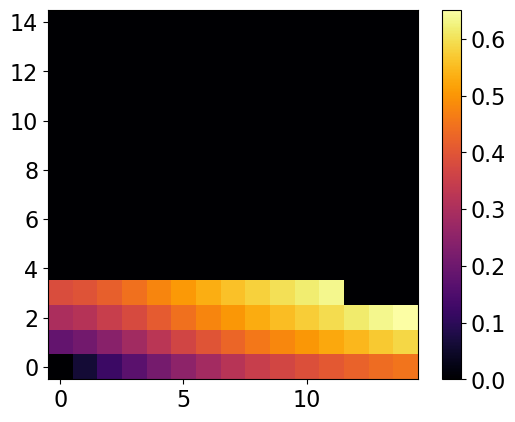

In [23]:
plt.imshow(array_95_check, cmap = 'inferno', origin='lower')
plt.colorbar()
plt.show()

### Reliability Diagrams

In [1]:
def rmsd_of_cal_curve(cal_curve):

    #compute root mean square deviation from ideal calibration line (the centre diagonal line)
    rmsd = np.sqrt((((cal_curve[0] - cal_curve[1])**2).sum()).mean())

    return rmsd

def compute_calibration_curve_and_errors(ensemble_members, event_threshold, ensemble_size, observed_data, num_bins):

    # # Generate probabilistic forecast from ensemble
    # probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, 
    #                                                         threshold=event_threshold, ensemble_size=ensemble_size)

    # define terms for calibration curve: generating proabilistic forecast from ensemble, binarising observed timeseries by event threshold
    y_prob = hef.gen_probabilistic_forecast(ensemble_members=ensemble_members, threshold=event_threshold, ensemble_size=ensemble_size)
    y_true = hef.generate_catagorical_forecast(forecast=observed_data['V'], threshold=event_threshold)

    # Bin probabilities
    bins = np.linspace(0, 1, num_bins + 1) # Generate bins
    bin_indices = np.digitize(y_prob, bins) # Return the indices of the bins to which each value in input array belongs.

    # Calculate percentage correct in each bin
    observed_frequency = []
    obs_err = []

    for bin_num in range(1, num_bins + 1):
        mask = (bin_indices == bin_num) # Create mask which isolates all forecast indices within bin being looped over
        percentage = np.mean(y_true[mask]) # calculate percentage as fraction of correct forecasts of binned indices
        observed_frequency.append(percentage)
        obs_err.append(percentage/np.sqrt(np.sum(y_true[mask])))

    # Calculate mean probability in each bin
    mean_probabilities = [(bins[i] + bins[i + 1]) / 2 for i in range(num_bins)]

    rmsd = rmsd_of_cal_curve((np.array(observed_frequency), np.array(mean_probabilities)))

    return mean_probabilities, observed_frequency, obs_err, rmsd

In [ ]:
for df_ in daily_ensemble_sets:
    df_['prob'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

mean_probabilities, observed_frequency, obs_err, rmsd = compute_calibration_curve_and_errors(ensemble_sets[i], event_threshold, ensemble_size, observed_data, num_bins)